#
# Prédiction Consommation totale d'énergie

In [154]:

# Import des librairies utilisées

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as plt
import category_encoders as ce
from datetime import datetime, date
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer
import shap


In [5]:

# Lecture des données

df = pd.read_csv('2016_Building_Energy_Benchmarking.csv')

##
## Partie analyse exploratoire

##
### Features engineering

In [7]:

# Filtrage des bâtiments résidentiels

df1 = df[(df['BuildingType']=='NonResidential')|(df['BuildingType']=='Nonresidential COS')|(df['BuildingType']=='Nonresidential WA')]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,...,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,...,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,...,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,False,NaN,Compliant,NaN,223.54,16.99
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,...,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,False,NaN,Compliant,NaN,22.11,1.57


In [9]:

# Fonction pour calculer l'âge des bâtiments

def years_build(year_b):
    year_b = str(year_b)
    year_b = datetime.strptime(year_b, "%Y").date()
    today= date.today()
    return today.year - year_b.year

df1['How_old_Building_is'] = df1['YearBuilt'].apply(years_build)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,How_old_Building_is
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,3.946027e+06,12764.529300,1.276453e+06,False,NaN,Compliant,NaN,249.98,2.83,95
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,3.242851e+06,51450.816410,5.145082e+06,False,NaN,Compliant,NaN,295.86,2.86,26
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,4.952666e+07,14938.000000,1.493800e+06,False,NaN,Compliant,NaN,2089.28,2.19,53
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,2.768924e+06,18112.130860,1.811213e+06,False,NaN,Compliant,NaN,286.43,4.67,96
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,5.368607e+06,88039.984380,8.803998e+06,False,NaN,Compliant,NaN,505.01,2.88,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,...,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70,32
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,...,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01,18
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,...,1.792159e+06,39737.390630,3.973739e+06,False,NaN,Compliant,NaN,223.54,16.99,48
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,...,3.488702e+05,3706.010010,3.706010e+05,False,NaN,Compliant,NaN,22.11,1.57,33


In [11]:
df2 = df1

In [12]:

# Création d'une colonne pour savoir si le bâtiment utilise du gaz

df2['Gas_used'] = df2['NaturalGas(kBtu)']!= 0.0
df2['Gas_used'] = df2['Gas_used'].astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,How_old_Building_is,Gas_used
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,12764.529300,1.276453e+06,False,NaN,Compliant,NaN,249.98,2.83,95,1
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,51450.816410,5.145082e+06,False,NaN,Compliant,NaN,295.86,2.86,26,1
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,14938.000000,1.493800e+06,False,NaN,Compliant,NaN,2089.28,2.19,53,1
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,18112.130860,1.811213e+06,False,NaN,Compliant,NaN,286.43,4.67,96,1
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,88039.984380,8.803998e+06,False,NaN,Compliant,NaN,505.01,2.88,42,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,...,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70,32,1
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,...,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01,18,1
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,...,39737.390630,3.973739e+06,False,NaN,Compliant,NaN,223.54,16.99,48,1
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,...,3706.010010,3.706010e+05,False,NaN,Compliant,NaN,22.11,1.57,33,1


In [13]:

# Création d'une colonne pour savoir si le bâtiment utilise de l'électricité

df2['Electricity_used'] = df2['Electricity(kBtu)']!= 0.0
df2['Electricity_used'] = df2['Electricity_used'].astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,How_old_Building_is,Gas_used,Electricity_used
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.276453e+06,False,NaN,Compliant,NaN,249.98,2.83,95,1,1
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,5.145082e+06,False,NaN,Compliant,NaN,295.86,2.86,26,1,1
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.493800e+06,False,NaN,Compliant,NaN,2089.28,2.19,53,1,1
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,1.811213e+06,False,NaN,Compliant,NaN,286.43,4.67,96,1,1
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,8.803998e+06,False,NaN,Compliant,NaN,505.01,2.88,42,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,...,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70,32,1,1
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,...,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01,18,1,1
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,...,3.973739e+06,False,NaN,Compliant,NaN,223.54,16.99,48,1,1
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,...,3.706010e+05,False,NaN,Compliant,NaN,22.11,1.57,33,1,1


In [14]:

# Création d'une colonne pour savoir si le bâtiment utilise de l'électricité

df2['Steam_used'] = df2['SteamUse(kBtu)']!= 0.0
df2['Steam_used'] = df2['Steam_used'].astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,How_old_Building_is,Gas_used,Electricity_used,Steam_used
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,False,NaN,Compliant,NaN,249.98,2.83,95,1,1,1
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,False,NaN,Compliant,NaN,295.86,2.86,26,1,1,0
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,False,NaN,Compliant,NaN,2089.28,2.19,53,1,1,1
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,False,NaN,Compliant,NaN,286.43,4.67,96,1,1,1
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,False,NaN,Compliant,NaN,505.01,2.88,42,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,...,True,NaN,Error - Correct Default Data,NaN,20.94,1.70,32,1,1,0
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,...,False,NaN,Compliant,NaN,32.17,2.01,18,1,1,0
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,...,False,NaN,Compliant,NaN,223.54,16.99,48,1,1,0
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,...,False,NaN,Compliant,NaN,22.11,1.57,33,1,1,0


In [15]:

# Création d'une colonne pour savoir si un bâtiment a un parking

df2['Parking_used'] = df2['PropertyGFAParking']!= 0.0
df2['Parking_used'] = df2['Parking_used'].astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,How_old_Building_is,Gas_used,Electricity_used,Steam_used,Parking_used
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,NaN,Compliant,NaN,249.98,2.83,95,1,1,1,0
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,NaN,Compliant,NaN,295.86,2.86,26,1,1,0,1
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,NaN,Compliant,NaN,2089.28,2.19,53,1,1,1,1
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,NaN,Compliant,NaN,286.43,4.67,96,1,1,1,0
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,NaN,Compliant,NaN,505.01,2.88,42,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,...,NaN,Error - Correct Default Data,NaN,20.94,1.70,32,1,1,0,0
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,...,NaN,Compliant,NaN,32.17,2.01,18,1,1,0,0
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,...,NaN,Compliant,NaN,223.54,16.99,48,1,1,0,0
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,...,NaN,Compliant,NaN,22.11,1.57,33,1,1,0,0


In [16]:

# Information sur les outliers

df2['Outlier'].unique()

array([nan, 'High outlier', 'Low outlier'], dtype=object)

In [17]:

# Filtrage des outliers

df2 = df2[(df2['Outlier']!='High outlier')]
df2 = df2[(df2['Outlier']!='Low outlier')]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,How_old_Building_is,Gas_used,Electricity_used,Steam_used,Parking_used
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,NaN,Compliant,NaN,249.98,2.83,95,1,1,1,0
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,NaN,Compliant,NaN,295.86,2.86,26,1,1,0,1
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,NaN,Compliant,NaN,2089.28,2.19,53,1,1,1,1
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,NaN,Compliant,NaN,286.43,4.67,96,1,1,1,0
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,NaN,Compliant,NaN,505.01,2.88,42,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,...,NaN,Error - Correct Default Data,NaN,20.94,1.70,32,1,1,0,0
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,...,NaN,Compliant,NaN,32.17,2.01,18,1,1,0,0
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,...,NaN,Compliant,NaN,223.54,16.99,48,1,1,0,0
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,...,NaN,Compliant,NaN,22.11,1.57,33,1,1,0,0


In [20]:

# Filtrage des valeurs nulles et négatives

df3 = df2.loc[-(df2['TotalGHGEmissions']<=0)]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,How_old_Building_is,Gas_used,Electricity_used,Steam_used,Parking_used
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,NaN,Compliant,NaN,249.98,2.83,95,1,1,1,0
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,NaN,Compliant,NaN,295.86,2.86,26,1,1,0,1
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,NaN,Compliant,NaN,2089.28,2.19,53,1,1,1,1
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,NaN,Compliant,NaN,286.43,4.67,96,1,1,1,0
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,NaN,Compliant,NaN,505.01,2.88,42,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,...,NaN,Error - Correct Default Data,NaN,20.94,1.70,32,1,1,0,0
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,...,NaN,Compliant,NaN,32.17,2.01,18,1,1,0,0
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,...,NaN,Compliant,NaN,223.54,16.99,48,1,1,0,0
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,...,NaN,Compliant,NaN,22.11,1.57,33,1,1,0,0


In [21]:

# Filtrage des NaN pour 'TotalGHGEmissions'

df4 = df3.loc[-(df3['TotalGHGEmissions'].isna())]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,How_old_Building_is,Gas_used,Electricity_used,Steam_used,Parking_used
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,NaN,Compliant,NaN,249.98,2.83,95,1,1,1,0
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,NaN,Compliant,NaN,295.86,2.86,26,1,1,0,1
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,NaN,Compliant,NaN,2089.28,2.19,53,1,1,1,1
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,NaN,Compliant,NaN,286.43,4.67,96,1,1,1,0
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,NaN,Compliant,NaN,505.01,2.88,42,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,...,NaN,Error - Correct Default Data,NaN,20.94,1.70,32,1,1,0,0
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,...,NaN,Compliant,NaN,32.17,2.01,18,1,1,0,0
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,...,NaN,Compliant,NaN,223.54,16.99,48,1,1,0,0
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,...,NaN,Compliant,NaN,22.11,1.57,33,1,1,0,0


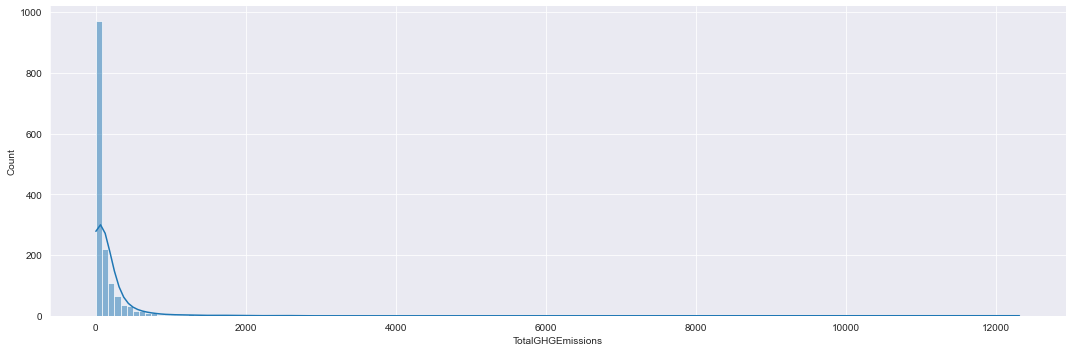

In [23]:

# Affichage de la distribution de la variable 'TotalGHGEmissions'

sns.displot(data = df4, x = 'TotalGHGEmissions', kde = True, aspect = 3, bins=150)

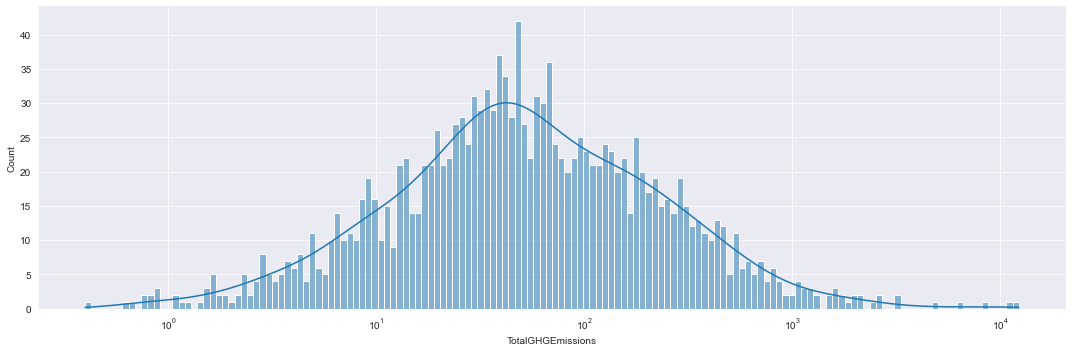

In [24]:

# Affichage de la distribution de la variable 'TotalGHGEmissions' avec échelle logarithmique

sns.displot(data = df4, x = 'TotalGHGEmissions', kde = True, aspect = 3, bins=150, log_scale=True)

In [26]:

# Filtrage des valeurs nulles ou négative pour la variable 'SiteEnergyUseWN(kBtu)'

df5 = df4.loc[-(df3['SiteEnergyUseWN(kBtu)'] <= 0.0)]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,How_old_Building_is,Gas_used,Electricity_used,Steam_used,Parking_used
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,NaN,Compliant,NaN,249.98,2.83,95,1,1,1,0
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,NaN,Compliant,NaN,295.86,2.86,26,1,1,0,1
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,NaN,Compliant,NaN,2089.28,2.19,53,1,1,1,1
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,NaN,Compliant,NaN,286.43,4.67,96,1,1,1,0
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,NaN,Compliant,NaN,505.01,2.88,42,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,...,NaN,Error - Correct Default Data,NaN,20.94,1.70,32,1,1,0,0
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,...,NaN,Compliant,NaN,32.17,2.01,18,1,1,0,0
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,...,NaN,Compliant,NaN,223.54,16.99,48,1,1,0,0
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,...,NaN,Compliant,NaN,22.11,1.57,33,1,1,0,0


In [27]:

# Filtrage des NaN pour la variable 'SiteEnergyUseWN(kBtu)'

df6 = df5.loc[-(df3['SiteEnergyUseWN(kBtu)'].isna())]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,How_old_Building_is,Gas_used,Electricity_used,Steam_used,Parking_used
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,NaN,Compliant,NaN,249.98,2.83,95,1,1,1,0
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,NaN,Compliant,NaN,295.86,2.86,26,1,1,0,1
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,NaN,Compliant,NaN,2089.28,2.19,53,1,1,1,1
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,NaN,Compliant,NaN,286.43,4.67,96,1,1,1,0
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,NaN,Compliant,NaN,505.01,2.88,42,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,...,NaN,Error - Correct Default Data,NaN,20.94,1.70,32,1,1,0,0
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,...,NaN,Compliant,NaN,32.17,2.01,18,1,1,0,0
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,...,NaN,Compliant,NaN,223.54,16.99,48,1,1,0,0
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,...,NaN,Compliant,NaN,22.11,1.57,33,1,1,0,0


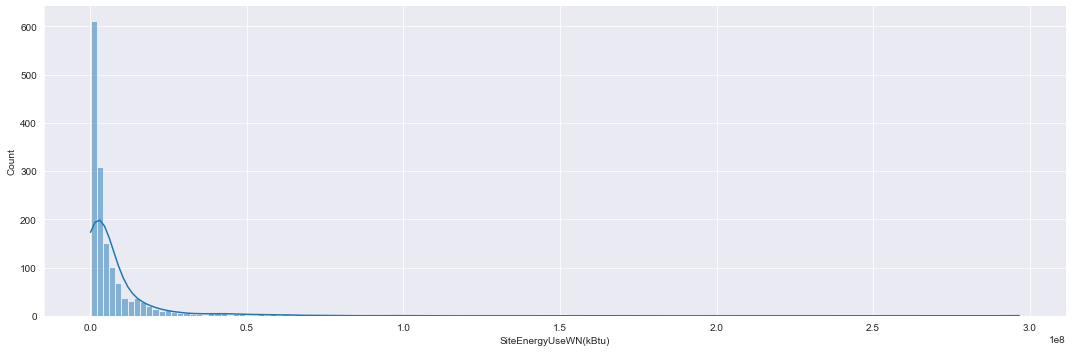

In [29]:

# Affichage de la distribution de la variable 'SiteEnergyUseWN(kBtu)'

sns.displot(data = df6, x = 'SiteEnergyUseWN(kBtu)', kde = True, aspect = 3, bins = 150)

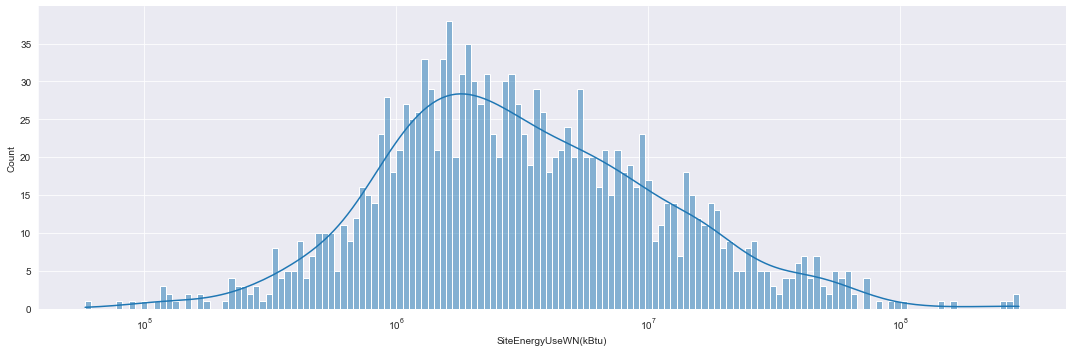

In [30]:

# Affichage de la distribution de la variable 'SiteEnergyUseWN(kBtu)' avec une échelle logarithmique

sns.displot(data = df6, x = 'SiteEnergyUseWN(kBtu)', kde = True, aspect = 3, bins = 150, log_scale = True)

In [31]:

# Sélection des features pertinentes pour notre étude

df7 = df6[['PrimaryPropertyType','Neighborhood', 'PropertyGFATotal', 'Parking_used', 'NumberofBuildings', 'NumberofFloors', 'How_old_Building_is', 'Electricity_used', 'Gas_used', 'Steam_used','SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']]

,PrimaryPropertyType,Neighborhood,PropertyGFATotal,Parking_used,NumberofBuildings,NumberofFloors,How_old_Building_is,Electricity_used,Gas_used,Steam_used,SiteEnergyUseWN(kBtu),TotalGHGEmissions
0,Hotel,DOWNTOWN,88434,0,1.0,12,95,1,1,1,7.456910e+06,249.98
1,Hotel,DOWNTOWN,103566,1,1.0,11,26,1,1,0,8.664479e+06,295.86
2,Hotel,DOWNTOWN,956110,1,1.0,41,53,1,1,1,7.393711e+07,2089.28
3,Hotel,DOWNTOWN,61320,0,1.0,10,96,1,1,1,6.946800e+06,286.43
4,Hotel,DOWNTOWN,175580,1,1.0,18,42,1,1,0,1.465650e+07,505.01
...,...,...,...,...,...,...,...,...,...,...,...,...
3371,Office,GREATER DUWAMISH,12294,0,1.0,1,32,1,1,0,9.430032e+05,20.94
3372,Other,DOWNTOWN,16000,0,1.0,1,18,1,1,0,1.053706e+06,32.17
3373,Other,MAGNOLIA / QUEEN ANNE,13157,0,1.0,1,48,1,1,0,6.053764e+06,223.54
3374,Mixed Use Property,GREATER DUWAMISH,14101,0,1.0,1,33,1,1,0,7.828413e+05,22.11


##
### One-Hot encoding

In [33]:

# Préparation des données pour le One-Hot encoding, sélection des variables catégorielles

categorial_df7 = df7.select_dtypes(include = 'object')
categorial_df7

,PrimaryPropertyType,Neighborhood
0,Hotel,DOWNTOWN
1,Hotel,DOWNTOWN
2,Hotel,DOWNTOWN
3,Hotel,DOWNTOWN
4,Hotel,DOWNTOWN
...,...,...
3371,Office,GREATER DUWAMISH
3372,Other,DOWNTOWN
3373,Other,MAGNOLIA / QUEEN ANNE
3374,Mixed Use Property,GREATER DUWAMISH


In [34]:

# Préparation des données pour le One-Hot encoding, sélection des variables numériques

numerical_df7 = df7.select_dtypes(include = ('int32', 'int64', 'float64'))
numerical_df7

,PropertyGFATotal,Parking_used,NumberofBuildings,NumberofFloors,How_old_Building_is,Electricity_used,Gas_used,Steam_used,SiteEnergyUseWN(kBtu),TotalGHGEmissions
0,88434,0,1.0,12,95,1,1,1,7.456910e+06,249.98
1,103566,1,1.0,11,26,1,1,0,8.664479e+06,295.86
2,956110,1,1.0,41,53,1,1,1,7.393711e+07,2089.28
3,61320,0,1.0,10,96,1,1,1,6.946800e+06,286.43
4,175580,1,1.0,18,42,1,1,0,1.465650e+07,505.01
...,...,...,...,...,...,...,...,...,...,...
3371,12294,0,1.0,1,32,1,1,0,9.430032e+05,20.94
3372,16000,0,1.0,1,18,1,1,0,1.053706e+06,32.17
3373,13157,0,1.0,1,48,1,1,0,6.053764e+06,223.54
3374,14101,0,1.0,1,33,1,1,0,7.828413e+05,22.11


In [35]:

# Création des variables dummies (pour les variables catégorielles)

categorial_df7_dummies = pd.get_dummies(categorial_df7)
categorial_df7_dummies

,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Office,...,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3373,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3374,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [36]:

# Concaténation de toutes les variables

df7_v1 = pd.concat([numerical_df7, categorial_df7_dummies], axis = 1)
df7_v1

,PropertyGFATotal,Parking_used,NumberofBuildings,NumberofFloors,How_old_Building_is,Electricity_used,Gas_used,Steam_used,SiteEnergyUseWN(kBtu),TotalGHGEmissions,...,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST
0,88434,0,1.0,12,95,1,1,1,7.456910e+06,249.98,...,0,0,0,0,0,0,0,0,0,0
1,103566,1,1.0,11,26,1,1,0,8.664479e+06,295.86,...,0,0,0,0,0,0,0,0,0,0
2,956110,1,1.0,41,53,1,1,1,7.393711e+07,2089.28,...,0,0,0,0,0,0,0,0,0,0
3,61320,0,1.0,10,96,1,1,1,6.946800e+06,286.43,...,0,0,0,0,0,0,0,0,0,0
4,175580,1,1.0,18,42,1,1,0,1.465650e+07,505.01,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,12294,0,1.0,1,32,1,1,0,9.430032e+05,20.94,...,1,0,0,0,0,0,0,0,0,0
3372,16000,0,1.0,1,18,1,1,0,1.053706e+06,32.17,...,0,0,0,0,0,0,0,0,0,0
3373,13157,0,1.0,1,48,1,1,0,6.053764e+06,223.54,...,0,0,1,0,0,0,0,0,0,0
3374,14101,0,1.0,1,33,1,1,0,7.828413e+05,22.11,...,1,0,0,0,0,0,0,0,0,0


In [37]:

# Passage au log pour les variables 'SiteEnergyUseWN(kBtu)' et 'TotalGHGEmissions'

df7_v1['SiteEnergyUseWN(kBtu)'] = np.log(df7_v1['SiteEnergyUseWN(kBtu)'])
df7_v1['TotalGHGEmissions'] = np.log(df7_v1['TotalGHGEmissions'])

,PropertyGFATotal,Parking_used,NumberofBuildings,NumberofFloors,How_old_Building_is,Electricity_used,Gas_used,Steam_used,SiteEnergyUseWN(kBtu),TotalGHGEmissions,...,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST
0,88434,0,1.0,12,95,1,1,1,15.824652,5.521381,...,0,0,0,0,0,0,0,0,0,0
1,103566,1,1.0,11,26,1,1,0,15.974742,5.689886,...,0,0,0,0,0,0,0,0,0,0
2,956110,1,1.0,41,53,1,1,1,18.118725,7.644575,...,0,0,0,0,0,0,0,0,0,0
3,61320,0,1.0,10,96,1,1,1,15.753792,5.657494,...,0,0,0,0,0,0,0,0,0,0
4,175580,1,1.0,18,42,1,1,0,16.500395,6.224578,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,12294,0,1.0,1,32,1,1,0,13.756825,3.041661,...,1,0,0,0,0,0,0,0,0,0
3372,16000,0,1.0,1,18,1,1,0,13.867824,3.471034,...,0,0,0,0,0,0,0,0,0,0
3373,13157,0,1.0,1,48,1,1,0,15.616191,5.409590,...,0,0,1,0,0,0,0,0,0,0
3374,14101,0,1.0,1,33,1,1,0,13.570685,3.096030,...,1,0,0,0,0,0,0,0,0,0


In [39]:
df8 = df7_v1
df8

##
## Section 1 : Modélisation

In [41]:
# On crée X et y dans le but de séparer les données d'entraînements et les données de tests

y = df8['SiteEnergyUseWN(kBtu)']
X = df8.drop(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'],axis = 1)



In [42]:
X

,PropertyGFATotal,Parking_used,NumberofBuildings,NumberofFloors,How_old_Building_is,Electricity_used,Gas_used,Steam_used,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Hospital,...,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST
0,88434,0,1.0,12,95,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,103566,1,1.0,11,26,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,956110,1,1.0,41,53,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,61320,0,1.0,10,96,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,175580,1,1.0,18,42,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,12294,0,1.0,1,32,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3372,16000,0,1.0,1,18,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3373,13157,0,1.0,1,48,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3374,14101,0,1.0,1,33,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [43]:

# On sépare jeu d'entrainement / jeu de test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 50)


In [44]:

# Mise à l'échelle de nos données

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


##
### Elastic Net

In [45]:

# Instantiation

elastic_net_model = ElasticNet(random_state = 50)


In [47]:

# Paramètres de la grille

param_grid = {'max_iter': [1000],
              "alpha": [0.1, 0.5, 1],
              "l1_ratio": [0,0.4, 0.5, 0.6,1]
             }



In [49]:

# Paramètres du GridSearchCV

grid_model = GridSearchCV(estimator = elastic_net_model,
                          param_grid = param_grid,
                          scoring = ['r2','neg_mean_squared_error','neg_mean_absolute_error'],
                          cv = 10,
                          refit = 'r2',
                          verbose = 1
                          )


In [50]:

# Entraînement du GridSearchCV

grid_model.fit(X_train, y_train)


Fitting 10 folds for each of 15 candidates, totalling 150 fits


Objective did not converge. You might want to increase the number of iterations. Duality gap: 377.17112564380295, tolerance: 0.1772613984399794
Objective did not converge. You might want to increase the number of iterations. Duality gap: 376.5617186539757, tolerance: 0.17840058003415024
Objective did not converge. You might want to increase the number of iterations. Duality gap: 378.97819300600906, tolerance: 0.17728587792353775
Objective did not converge. You might want to increase the number of iterations. Duality gap: 391.0210457211807, tolerance: 0.17913725222848093
Objective did not converge. You might want to increase the number of iterations. Duality gap: 390.28519831353026, tolerance: 0.17982874132587415
Objective did not converge. You might want to increase the number of iterations. Duality gap: 376.7455183464862, tolerance: 0.17865165932733912
Objective did not converge. You might want to increase the number of iterations. Duality gap: 385.4192529765438, tolerance: 0.18152620

GridSearchCV(cv=10, estimator=ElasticNet(random_state=50),
             param_grid={'alpha': [0.1, 0.5, 1],
                         'l1_ratio': [0, 0.4, 0.5, 0.6, 1],
                         'max_iter': [1000]},
             refit='r2',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_mean_absolute_error'],
             verbose=1)

In [51]:

# Obtention du meilleur estimateur

grid_model.best_estimator_


ElasticNet(alpha=0.1, l1_ratio=0, random_state=50)

In [52]:

# Affichage du meilleur score (r2)

grid_model.best_score_

0.5694989940748115

In [53]:

# Affichage des meilleurs paramètres

grid_model.best_params_


{'alpha': 0.1, 'l1_ratio': 0, 'max_iter': 1000}

In [54]:

# On place les différents résultats dans un DataFrame

r2_elastic_net= pd.DataFrame(grid_model.cv_results_)
r2_elastic_net


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,param_max_iter,params,split0_test_r2,split1_test_r2,...,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,split5_test_neg_mean_absolute_error,split6_test_neg_mean_absolute_error,split7_test_neg_mean_absolute_error,split8_test_neg_mean_absolute_error,split9_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,0.310178,0.151074,0.006822,0.001582,0.1,0,1000,"{'alpha': 0.1, 'l1_ratio': 0, 'max_iter': 1000}",0.534097,0.506687,...,-0.594027,-0.589035,-0.705479,-0.605826,-0.682014,-0.646777,-0.652817,-0.652340,0.041174,1
1,0.012456,0.001620,0.006647,0.001034,0.1,0.4,1000,"{'alpha': 0.1, 'l1_ratio': 0.4, 'max_iter': 1000}",0.541544,0.508037,...,-0.636028,-0.623498,-0.722662,-0.621084,-0.671987,-0.644524,-0.685875,-0.668478,0.033690,2
2,0.010535,0.001555,0.005771,0.000933,0.1,0.5,1000,"{'alpha': 0.1, 'l1_ratio': 0.5, 'max_iter': 1000}",0.534423,0.499346,...,-0.643314,-0.636485,-0.730652,-0.627201,-0.673612,-0.650434,-0.694670,-0.675800,0.033615,3
3,0.009068,0.000976,0.005650,0.001386,0.1,0.6,1000,"{'alpha': 0.1, 'l1_ratio': 0.6, 'max_iter': 1000}",0.526668,0.491825,...,-0.651491,-0.650200,-0.739444,-0.634229,-0.678059,-0.657495,-0.702915,-0.683839,0.033400,5
4,0.009923,0.003051,0.005204,0.000387,0.1,1,1000,"{'alpha': 0.1, 'l1_ratio': 1, 'max_iter': 1000}",0.480618,0.452079,...,-0.694562,-0.700421,-0.775533,-0.657547,-0.701263,-0.694382,-0.736664,-0.720539,0.035559,7
5,0.299342,0.080780,0.005820,0.001193,0.5,0,1000,"{'alpha': 0.5, 'l1_ratio': 0, 'max_iter': 1000}",0.539957,0.477436,...,-0.625554,-0.636497,-0.732169,-0.619560,-0.690484,-0.660196,-0.685198,-0.677439,0.038252,4
6,0.016110,0.006481,0.008856,0.005915,0.5,0.4,1000,"{'alpha': 0.5, 'l1_ratio': 0.4, 'max_iter': 1000}",0.350514,0.305575,...,-0.840158,-0.818199,-0.858917,-0.753252,-0.806196,-0.785760,-0.845541,-0.829613,0.036797,8
7,0.010006,0.001227,0.006721,0.002000,0.5,0.5,1000,"{'alpha': 0.5, 'l1_ratio': 0.5, 'max_iter': 1000}",0.325577,0.268835,...,-0.863326,-0.840816,-0.881855,-0.778421,-0.830177,-0.799825,-0.868241,-0.851181,0.037040,9
8,0.008655,0.002558,0.005814,0.001882,0.5,0.6,1000,"{'alpha': 0.5, 'l1_ratio': 0.6, 'max_iter': 1000}",0.311172,0.239201,...,-0.883676,-0.857610,-0.890847,-0.799019,-0.851892,-0.819933,-0.885999,-0.868139,0.034996,10
9,0.007089,0.001136,0.004107,0.000700,0.5,1,1000,"{'alpha': 0.5, 'l1_ratio': 1, 'max_iter': 1000}",0.247672,0.182200,...,-0.921892,-0.905074,-0.927063,-0.839751,-0.908710,-0.875250,-0.933576,-0.911529,0.031524,11


In [55]:

# Fonction qui nous sert à afficher les résultats r2, MSE, MAE, RMSE

def display_indicators (a):
    max_r2 = max(a.cv_results_['mean_test_r2'])
    max_MSE= max(a.cv_results_['mean_test_neg_mean_squared_error'])
    max_MAE= max(a.cv_results_['mean_test_neg_mean_absolute_error'])
    max_RMSE = np.sqrt(-max_MSE)
    print("La valeur de max R2 est : ", max_r2)
    print("La valeur de max MSE est : ", max_MSE)
    print("La valeur de max MAE est : ", max_MAE)
    print("La valeur de max RMSE est : ", max_RMSE)

    return max_r2, max_MSE, max_MAE, max_RMSE


In [56]:

# Affichage des résultats pour nos meilleurs paramètres

a0 = display_indicators(grid_model)

La valeur de max R2 est :  0.5694989940748115
La valeur de max MSE est :  -0.7027465381146291
La valeur de max MAE est :  -0.6523404038003097
La valeur de max RMSE est :  0.838299790119638


##
### SVM

In [57]:

# Instantiation

svr_model = SVR()

In [58]:

# Paramètres de la grille pour le Support Vector Regression

param_Grid_1 = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],      # noyau
                'C' : [1,5,10],                                       # paramètre de régularisation
                'degree' : [3,8],                                     # noyau polynomial
                'gamma' : ['auto','scale']
                }




In [59]:

# Paramètres du GridSearchCV

grid_model_1 = GridSearchCV(svr_model,
                            param_Grid_1,
                            scoring = ['r2','neg_mean_squared_error','neg_mean_absolute_error'],
                            cv = 10,
                            refit = 'r2',
                            verbose = 1
                            )

In [60]:

# Entraînement du modèle

grid_model_1.fit(X_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'C': [1, 5, 10], 'degree': [3, 8],
                         'gamma': ['auto', 'scale'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             refit='r2',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_mean_absolute_error'],
             verbose=1)

In [61]:

# Obtention des meilleurs paramètres

grid_model_1.best_params_

{'C': 5, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}

In [62]:

# On place les résultats dans un DataFrame

svr_model_result= pd.DataFrame(grid_model_1.cv_results_)
svr_model_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_gamma,param_kernel,params,split0_test_r2,...,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,split5_test_neg_mean_absolute_error,split6_test_neg_mean_absolute_error,split7_test_neg_mean_absolute_error,split8_test_neg_mean_absolute_error,split9_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,1.026230,0.154907,0.019630,0.005394,1,3,auto,linear,"{'C': 1, 'degree': 3, 'gamma': 'auto', 'kernel...",0.491290,...,-0.586304,-0.570212,-0.735896,-0.606579,-0.667845,-0.660649,-0.645450,-0.648097,0.046785,21
1,0.425260,0.033885,0.033502,0.007848,1,3,auto,poly,"{'C': 1, 'degree': 3, 'gamma': 'auto', 'kernel...",0.439879,...,-0.631666,-0.693398,-0.760324,-0.660682,-0.707324,-0.713151,-0.719139,-0.715053,0.043313,30
2,0.398580,0.078596,0.084136,0.016282,1,3,auto,rbf,"{'C': 1, 'degree': 3, 'gamma': 'auto', 'kernel...",0.482507,...,-0.581001,-0.597754,-0.692121,-0.565966,-0.608837,-0.608602,-0.600092,-0.625676,0.051349,9
3,0.465232,0.053605,0.040986,0.007853,1,3,auto,sigmoid,"{'C': 1, 'degree': 3, 'gamma': 'auto', 'kernel...",-3.459098,...,-0.745119,-0.859815,-1.000225,-0.950231,-1.036704,-1.044720,-1.028902,-0.943472,0.103009,31
4,1.289177,0.166075,0.025390,0.004716,1,3,scale,linear,"{'C': 1, 'degree': 3, 'gamma': 'scale', 'kerne...",0.491290,...,-0.586304,-0.570212,-0.735896,-0.606579,-0.667845,-0.660649,-0.645450,-0.648097,0.046785,21
5,0.373349,0.041111,0.028788,0.008003,1,3,scale,poly,"{'C': 1, 'degree': 3, 'gamma': 'scale', 'kerne...",0.445096,...,-0.628781,-0.693492,-0.757801,-0.659820,-0.707198,-0.709222,-0.718584,-0.713383,0.043202,29
6,0.389179,0.036043,0.093281,0.021279,1,3,scale,rbf,"{'C': 1, 'degree': 3, 'gamma': 'scale', 'kerne...",0.476016,...,-0.581448,-0.597738,-0.692935,-0.566213,-0.608850,-0.609642,-0.600502,-0.626403,0.052095,11
7,0.404678,0.040371,0.033120,0.004205,1,3,scale,sigmoid,"{'C': 1, 'degree': 3, 'gamma': 'scale', 'kerne...",-4.453385,...,-0.753120,-0.869078,-1.018920,-0.965156,-1.032456,-1.064246,-1.030739,-0.954601,0.109104,33
8,1.507876,0.281829,0.027209,0.004735,1,8,auto,linear,"{'C': 1, 'degree': 8, 'gamma': 'auto', 'kernel...",0.491290,...,-0.586304,-0.570212,-0.735896,-0.606579,-0.667845,-0.660649,-0.645450,-0.648097,0.046785,21
9,0.587703,0.060099,0.036144,0.005059,1,8,auto,poly,"{'C': 1, 'degree': 8, 'gamma': 'auto', 'kernel...",-149.480415,...,-0.824766,-1.001832,-0.918828,-0.862226,-0.879700,-1.130505,-1.019312,-1.098218,0.435650,38


In [63]:

# On affiche les résultats pour nos meilleurs paramètres

a1 = display_indicators(grid_model_1)

La valeur de max R2 est :  0.6140553109364688
La valeur de max MSE est :  -0.630965734825956
La valeur de max MAE est :  -0.6101343142857297
La valeur de max RMSE est :  0.7943335161164711


##
### Xg Boost

In [64]:

# Instantiation

xgb_model = XGBRegressor()

In [65]:

# Paramètres de la grille pour le XGBoost Regressor

param_Grid_2 = {'learning_rate' : [0.001, 0.1, 0.2],      # Taux d'apprentissage
                'subsample' : [0.3, 0.5, 0.7],            # Ratio des sous-échantillons
                'max_depth': [4,8],                       # Profondeur max de chaque arbre
                'gamma': [0, 0.25, 0.5, 1.0],             # Perte minimale pour faire un nouveau noeud
                'alpha' : [0.001, 0.1,1,10]               # Regularisation F1 sur les poids
                }



In [66]:

# Paramètres du GridSearchCV

grid_model_2 = GridSearchCV(estimator = xgb_model,
                            param_grid = param_Grid_2,
                            scoring = ['r2','neg_mean_squared_error','neg_mean_absolute_error'],
                            refit = 'r2',
                            cv = 10,
                            verbose = 1
                            )

In [67]:

# Entraînement du modèle

grid_model_2.fit(X_train, y_train)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_ca...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                               

In [68]:

# Obtention des meilleurs paramètres

grid_model_2.best_params_

{'alpha': 0.1,
 'gamma': 0.5,
 'learning_rate': 0.1,
 'max_depth': 4,
 'subsample': 0.7}

In [69]:

# On place tous les résultats dans un DataFrame

xgb_model_result= pd.DataFrame(grid_model_2.cv_results_)
xgb_model_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_gamma,param_learning_rate,param_max_depth,param_subsample,params,...,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,split5_test_neg_mean_absolute_error,split6_test_neg_mean_absolute_error,split7_test_neg_mean_absolute_error,split8_test_neg_mean_absolute_error,split9_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,0.346030,0.037781,0.011438,0.001974,0.001,0,0.001,4,0.3,"{'alpha': 0.001, 'gamma': 0, 'learning_rate': ...",...,-12.966251,-13.025095,-13.106603,-13.205674,-13.006248,-13.109063,-13.083102,-13.066934,0.072970,279
1,0.377682,0.043225,0.010836,0.002100,0.001,0,0.001,4,0.5,"{'alpha': 0.001, 'gamma': 0, 'learning_rate': ...",...,-12.963649,-13.017157,-13.107442,-13.200731,-13.003457,-13.108210,-13.078582,-13.064822,0.072763,233
2,0.339953,0.032193,0.009391,0.001128,0.001,0,0.001,4,0.7,"{'alpha': 0.001, 'gamma': 0, 'learning_rate': ...",...,-12.962629,-13.014411,-13.106937,-13.199016,-13.001551,-13.106226,-13.077333,-13.063337,0.072735,193
3,0.260397,0.030824,0.008822,0.001241,0.001,0,0.001,8,0.3,"{'alpha': 0.001, 'gamma': 0, 'learning_rate': ...",...,-12.966251,-13.025095,-13.106603,-13.205674,-13.006248,-13.109063,-13.083102,-13.066934,0.072970,279
4,0.405505,0.077375,0.012139,0.003101,0.001,0,0.001,8,0.5,"{'alpha': 0.001, 'gamma': 0, 'learning_rate': ...",...,-12.963649,-13.017157,-13.107442,-13.200731,-13.003457,-13.108210,-13.078582,-13.064822,0.072763,233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.331019,0.028991,0.008347,0.000649,10,1.0,0.2,4,0.5,"{'alpha': 10, 'gamma': 1.0, 'learning_rate': 0...",...,-0.510872,-0.504063,-0.568539,-0.531618,-0.529004,-0.558940,-0.484630,-0.540827,0.032261,144
284,0.371475,0.016921,0.009141,0.000619,10,1.0,0.2,4,0.7,"{'alpha': 10, 'gamma': 1.0, 'learning_rate': 0...",...,-0.520298,-0.491356,-0.556594,-0.509272,-0.520519,-0.536013,-0.510276,-0.534096,0.027795,110
285,0.440636,0.047979,0.008589,0.000686,10,1.0,0.2,8,0.3,"{'alpha': 10, 'gamma': 1.0, 'learning_rate': 0...",...,-0.515618,-0.505277,-0.598644,-0.536506,-0.511877,-0.546744,-0.493703,-0.542782,0.036355,151
286,0.428989,0.030334,0.008641,0.000631,10,1.0,0.2,8,0.5,"{'alpha': 10, 'gamma': 1.0, 'learning_rate': 0...",...,-0.513302,-0.511597,-0.571246,-0.525136,-0.522750,-0.534729,-0.498186,-0.538355,0.027088,135


In [70]:

# On affiche les meilleurs résultats pour paramètres

a2 = display_indicators(grid_model_2)

La valeur de max R2 est :  0.7284705940253733
La valeur de max MSE est :  -0.4431839413490778
La valeur de max MAE est :  -0.5090112717471975
La valeur de max RMSE est :  0.6657206180892085


##
### Random Forest

In [71]:

# Instantiation

rfr = RandomForestRegressor(n_jobs = -1, random_state = 50)

In [72]:

# Paramètres de la grille pour le Random Forest

param_Grid_3 = {'criterion': ["mse", "mae"],
                'max_depth': [10,12,14, None],              # Profondeur max de chaque arbre.
                'min_samples_leaf': [1,4,8,12],             # Nombre minimum d'individu pour être sur une feuille
                'max_features': ['auto','sqrt', None]       # Nombre de features sélectionner pour une meilleure répartition
                }                                           # None : n_features


In [73]:

# Paramètre du GridSearchCV

grid_model_3 = GridSearchCV(estimator = rfr,
                            param_grid = param_Grid_3,
                            scoring = ['r2','neg_mean_squared_error','neg_mean_absolute_error'],
                            refit = 'r2',
                            cv = 10,
                            verbose = 1
                            )


In [74]:

# Entraînement du modèle

grid_model_3.fit(X_train, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(n_jobs=-1, random_state=50),
             param_grid={'criterion': ['mse', 'mae'],
                         'max_depth': [10, 12, 14, None],
                         'max_features': ['auto', 'sqrt', None],
                         'min_samples_leaf': [1, 4, 8, 12]},
             refit='r2',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_mean_absolute_error'],
             verbose=1)

In [75]:

# Affichage des meilleurs paramètres du Random Forest

grid_model_3.best_params_

{'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1}

In [76]:

# On place les résultats dans un DataFrame

random_forest_result = pd.DataFrame(grid_model_3.cv_results_)
random_forest_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,params,split0_test_r2,...,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,split5_test_neg_mean_absolute_error,split6_test_neg_mean_absolute_error,split7_test_neg_mean_absolute_error,split8_test_neg_mean_absolute_error,split9_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,1.032621,2.124136,0.041705,0.007833,mse,10,auto,1,"{'criterion': 'mse', 'max_depth': 10, 'max_fea...",0.718449,...,-0.478305,-0.486687,-0.537781,-0.477214,-0.513019,-0.531788,-0.524029,-0.527900,0.038447,1
1,0.319502,0.019461,0.040653,0.001425,mse,10,auto,4,"{'criterion': 'mse', 'max_depth': 10, 'max_fea...",0.700932,...,-0.506633,-0.517453,-0.542382,-0.488319,-0.532801,-0.550950,-0.513091,-0.539681,0.032712,18
2,0.300818,0.010537,0.043263,0.002062,mse,10,auto,8,"{'criterion': 'mse', 'max_depth': 10, 'max_fea...",0.657862,...,-0.536852,-0.541440,-0.569533,-0.501245,-0.556946,-0.565101,-0.530259,-0.560834,0.033118,39
3,0.300689,0.049184,0.041338,0.006525,mse,10,auto,12,"{'criterion': 'mse', 'max_depth': 10, 'max_fea...",0.634880,...,-0.549063,-0.549796,-0.596706,-0.515475,-0.572424,-0.578088,-0.536505,-0.575584,0.037108,63
4,0.233796,0.044170,0.034871,0.006741,mse,10,sqrt,1,"{'criterion': 'mse', 'max_depth': 10, 'max_fea...",0.671751,...,-0.532513,-0.511898,-0.606062,-0.512578,-0.577875,-0.581034,-0.548296,-0.564683,0.033952,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.789650,0.108132,0.062174,0.009405,mae,None,sqrt,12,"{'criterion': 'mae', 'max_depth': None, 'max_f...",0.535139,...,-0.628349,-0.608438,-0.667684,-0.578931,-0.646048,-0.686792,-0.598887,-0.638178,0.033182,94
92,5.995631,0.807716,0.086475,0.034513,mae,None,None,1,"{'criterion': 'mae', 'max_depth': None, 'max_f...",0.718553,...,-0.500705,-0.475728,-0.558351,-0.489663,-0.523844,-0.532304,-0.539202,-0.535902,0.037094,14
93,3.865664,0.509091,0.067196,0.011230,mae,None,None,4,"{'criterion': 'mae', 'max_depth': None, 'max_f...",0.696627,...,-0.528264,-0.503399,-0.537190,-0.487504,-0.550536,-0.558000,-0.514049,-0.541177,0.031687,22
94,2.733710,0.153445,0.078982,0.027135,mae,None,None,8,"{'criterion': 'mae', 'max_depth': None, 'max_f...",0.659882,...,-0.553339,-0.533381,-0.573050,-0.500371,-0.578866,-0.570521,-0.525677,-0.563434,0.033627,49


In [77]:

# Affichage des meilleurs résultats pour nos paramètres

a3 = display_indicators(grid_model_3)

La valeur de max R2 est :  0.7043693928813453
La valeur de max MSE est :  -0.4829605925070489
La valeur de max MAE est :  -0.5279001719432789
La valeur de max RMSE est :  0.694953662129389


##
## Section 2 : Target encoding

In [78]:

# Sélection des variables pour le target encoding

df10 = df6[['Neighborhood',
           'PropertyGFATotal',
           'LargestPropertyUseType',
           'LargestPropertyUseTypeGFA',
           'SecondLargestPropertyUseType',
           'SecondLargestPropertyUseTypeGFA',
           'ThirdLargestPropertyUseType',
           'ThirdLargestPropertyUseTypeGFA',
           'Parking_used', 'NumberofBuildings',
           'NumberofFloors',
           'How_old_Building_is',
           'Electricity_used',
           'Gas_used',
           'Steam_used',
           'SiteEnergyUseWN(kBtu)',
           'TotalGHGEmissions']]


In [79]:
df10

,Neighborhood,PropertyGFATotal,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,Parking_used,NumberofBuildings,NumberofFloors,How_old_Building_is,Electricity_used,Gas_used,Steam_used,SiteEnergyUseWN(kBtu),TotalGHGEmissions
0,DOWNTOWN,88434,Hotel,88434.0,NaN,NaN,NaN,NaN,0,1.0,12,95,1,1,1,7.456910e+06,249.98
1,DOWNTOWN,103566,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,1,1.0,11,26,1,1,0,8.664479e+06,295.86
2,DOWNTOWN,956110,Hotel,756493.0,NaN,NaN,NaN,NaN,1,1.0,41,53,1,1,1,7.393711e+07,2089.28
3,DOWNTOWN,61320,Hotel,61320.0,NaN,NaN,NaN,NaN,0,1.0,10,96,1,1,1,6.946800e+06,286.43
4,DOWNTOWN,175580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,1,1.0,18,42,1,1,0,1.465650e+07,505.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,GREATER DUWAMISH,12294,Office,12294.0,NaN,NaN,NaN,NaN,0,1.0,1,32,1,1,0,9.430032e+05,20.94
3372,DOWNTOWN,16000,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,0,1.0,1,18,1,1,0,1.053706e+06,32.17
3373,MAGNOLIA / QUEEN ANNE,13157,Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,0,1.0,1,48,1,1,0,6.053764e+06,223.54
3374,GREATER DUWAMISH,14101,Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,0,1.0,1,33,1,1,0,7.828413e+05,22.11


In [80]:
df11 = df10

In [81]:

# Calcul en pourcentage des surfaces de 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'

df11.loc[:, ['LargestPropertyUseTypeGFA_%']] = ((df11['LargestPropertyUseTypeGFA']/df11['PropertyGFATotal'])*100).copy()
df11.loc[:, ['SecondLargestPropertyUseTypeGFA_%']] = ((df11['SecondLargestPropertyUseTypeGFA']/df11['PropertyGFATotal'])*100).copy()
df11.loc[:, ['ThirdLargestPropertyUseTypeGFA_%']] = ((df11['ThirdLargestPropertyUseTypeGFA']/df11['PropertyGFATotal'])*100).copy()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [82]:
df11

,Neighborhood,PropertyGFATotal,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,Parking_used,NumberofBuildings,NumberofFloors,How_old_Building_is,Electricity_used,Gas_used,Steam_used,SiteEnergyUseWN(kBtu),TotalGHGEmissions,LargestPropertyUseTypeGFA_%,SecondLargestPropertyUseTypeGFA_%,ThirdLargestPropertyUseTypeGFA_%
0,DOWNTOWN,88434,Hotel,88434.0,NaN,NaN,NaN,NaN,0,1.0,12,95,1,1,1,7.456910e+06,249.98,100.000000,NaN,NaN
1,DOWNTOWN,103566,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,1,1.0,11,26,1,1,0,8.664479e+06,295.86,80.991831,14.545314,4.462855
2,DOWNTOWN,956110,Hotel,756493.0,NaN,NaN,NaN,NaN,1,1.0,41,53,1,1,1,7.393711e+07,2089.28,79.121963,NaN,NaN
3,DOWNTOWN,61320,Hotel,61320.0,NaN,NaN,NaN,NaN,0,1.0,10,96,1,1,1,6.946800e+06,286.43,100.000000,NaN,NaN
4,DOWNTOWN,175580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,1,1.0,18,42,1,1,0,1.465650e+07,505.01,70.306983,38.733910,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,GREATER DUWAMISH,12294,Office,12294.0,NaN,NaN,NaN,NaN,0,1.0,1,32,1,1,0,9.430032e+05,20.94,100.000000,NaN,NaN
3372,DOWNTOWN,16000,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,0,1.0,1,18,1,1,0,1.053706e+06,32.17,100.000000,NaN,NaN
3373,MAGNOLIA / QUEEN ANNE,13157,Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,0,1.0,1,48,1,1,0,6.053764e+06,223.54,57.634719,42.365281,0.000000
3374,GREATER DUWAMISH,14101,Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,0,1.0,1,33,1,1,0,7.828413e+05,22.11,46.812283,46.103113,3.432381


In [83]:

# Comme nous avons calculer les %, on supprime les variables liées à ces %

df12 = df11.drop(['PropertyGFATotal', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'], axis = 1)

In [84]:

# Affichage des NaN

df12.isna().sum(axis = 0)

Neighborhood                            0
LargestPropertyUseType                  4
SecondLargestPropertyUseType          686
ThirdLargestPropertyUseType          1174
Parking_used                            0
NumberofBuildings                       0
NumberofFloors                          0
How_old_Building_is                     0
Electricity_used                        0
Gas_used                                0
Steam_used                              0
SiteEnergyUseWN(kBtu)                   0
TotalGHGEmissions                       0
LargestPropertyUseTypeGFA_%             4
SecondLargestPropertyUseTypeGFA_%     686
ThirdLargestPropertyUseTypeGFA_%     1174
dtype: int64

In [85]:

# On fait l'hypothèse que si on a des NaN pour une surface, on considère la valeur nulle

df12['LargestPropertyUseTypeGFA_%'] = df12['LargestPropertyUseTypeGFA_%'].fillna(0)
df12['SecondLargestPropertyUseTypeGFA_%'] = df12['SecondLargestPropertyUseTypeGFA_%'].fillna(0)
df12['ThirdLargestPropertyUseTypeGFA_%'] = df12['ThirdLargestPropertyUseTypeGFA_%'].fillna(0)

In [86]:
df12

,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Parking_used,NumberofBuildings,NumberofFloors,How_old_Building_is,Electricity_used,Gas_used,Steam_used,SiteEnergyUseWN(kBtu),TotalGHGEmissions,LargestPropertyUseTypeGFA_%,SecondLargestPropertyUseTypeGFA_%,ThirdLargestPropertyUseTypeGFA_%
0,DOWNTOWN,Hotel,NaN,NaN,0,1.0,12,95,1,1,1,7.456910e+06,249.98,100.000000,0.000000,0.000000
1,DOWNTOWN,Hotel,Parking,Restaurant,1,1.0,11,26,1,1,0,8.664479e+06,295.86,80.991831,14.545314,4.462855
2,DOWNTOWN,Hotel,NaN,NaN,1,1.0,41,53,1,1,1,7.393711e+07,2089.28,79.121963,0.000000,0.000000
3,DOWNTOWN,Hotel,NaN,NaN,0,1.0,10,96,1,1,1,6.946800e+06,286.43,100.000000,0.000000,0.000000
4,DOWNTOWN,Hotel,Parking,Swimming Pool,1,1.0,18,42,1,1,0,1.465650e+07,505.01,70.306983,38.733910,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,GREATER DUWAMISH,Office,NaN,NaN,0,1.0,1,32,1,1,0,9.430032e+05,20.94,100.000000,0.000000,0.000000
3372,DOWNTOWN,Other - Recreation,NaN,NaN,0,1.0,1,18,1,1,0,1.053706e+06,32.17,100.000000,0.000000,0.000000
3373,MAGNOLIA / QUEEN ANNE,Other - Recreation,Fitness Center/Health Club/Gym,Swimming Pool,0,1.0,1,48,1,1,0,6.053764e+06,223.54,57.634719,42.365281,0.000000
3374,GREATER DUWAMISH,Other - Recreation,Fitness Center/Health Club/Gym,Pre-school/Daycare,0,1.0,1,33,1,1,0,7.828413e+05,22.11,46.812283,46.103113,3.432381


In [87]:

# Mise au log des variables à prédire

df12['SiteEnergyUseWN(kBtu)'] = np.log(df12['SiteEnergyUseWN(kBtu)'])
df12['TotalGHGEmissions'] = np.log(df12['TotalGHGEmissions'])
df12

,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Parking_used,NumberofBuildings,NumberofFloors,How_old_Building_is,Electricity_used,Gas_used,Steam_used,SiteEnergyUseWN(kBtu),TotalGHGEmissions,LargestPropertyUseTypeGFA_%,SecondLargestPropertyUseTypeGFA_%,ThirdLargestPropertyUseTypeGFA_%
0,DOWNTOWN,Hotel,NaN,NaN,0,1.0,12,95,1,1,1,15.824652,5.521381,100.000000,0.000000,0.000000
1,DOWNTOWN,Hotel,Parking,Restaurant,1,1.0,11,26,1,1,0,15.974742,5.689886,80.991831,14.545314,4.462855
2,DOWNTOWN,Hotel,NaN,NaN,1,1.0,41,53,1,1,1,18.118725,7.644575,79.121963,0.000000,0.000000
3,DOWNTOWN,Hotel,NaN,NaN,0,1.0,10,96,1,1,1,15.753792,5.657494,100.000000,0.000000,0.000000
4,DOWNTOWN,Hotel,Parking,Swimming Pool,1,1.0,18,42,1,1,0,16.500395,6.224578,70.306983,38.733910,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,GREATER DUWAMISH,Office,NaN,NaN,0,1.0,1,32,1,1,0,13.756825,3.041661,100.000000,0.000000,0.000000
3372,DOWNTOWN,Other - Recreation,NaN,NaN,0,1.0,1,18,1,1,0,13.867824,3.471034,100.000000,0.000000,0.000000
3373,MAGNOLIA / QUEEN ANNE,Other - Recreation,Fitness Center/Health Club/Gym,Swimming Pool,0,1.0,1,48,1,1,0,15.616191,5.409590,57.634719,42.365281,0.000000
3374,GREATER DUWAMISH,Other - Recreation,Fitness Center/Health Club/Gym,Pre-school/Daycare,0,1.0,1,33,1,1,0,13.570685,3.096030,46.812283,46.103113,3.432381


In [88]:

# On fait l'hypothèse que si une valeur n'est pas indiqué, on la passe à 0

df13 = df12.fillna(0)
df13

,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Parking_used,NumberofBuildings,NumberofFloors,How_old_Building_is,Electricity_used,Gas_used,Steam_used,SiteEnergyUseWN(kBtu),TotalGHGEmissions,LargestPropertyUseTypeGFA_%,SecondLargestPropertyUseTypeGFA_%,ThirdLargestPropertyUseTypeGFA_%
0,DOWNTOWN,Hotel,0,0,0,1.0,12,95,1,1,1,15.824652,5.521381,100.000000,0.000000,0.000000
1,DOWNTOWN,Hotel,Parking,Restaurant,1,1.0,11,26,1,1,0,15.974742,5.689886,80.991831,14.545314,4.462855
2,DOWNTOWN,Hotel,0,0,1,1.0,41,53,1,1,1,18.118725,7.644575,79.121963,0.000000,0.000000
3,DOWNTOWN,Hotel,0,0,0,1.0,10,96,1,1,1,15.753792,5.657494,100.000000,0.000000,0.000000
4,DOWNTOWN,Hotel,Parking,Swimming Pool,1,1.0,18,42,1,1,0,16.500395,6.224578,70.306983,38.733910,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,GREATER DUWAMISH,Office,0,0,0,1.0,1,32,1,1,0,13.756825,3.041661,100.000000,0.000000,0.000000
3372,DOWNTOWN,Other - Recreation,0,0,0,1.0,1,18,1,1,0,13.867824,3.471034,100.000000,0.000000,0.000000
3373,MAGNOLIA / QUEEN ANNE,Other - Recreation,Fitness Center/Health Club/Gym,Swimming Pool,0,1.0,1,48,1,1,0,15.616191,5.409590,57.634719,42.365281,0.000000
3374,GREATER DUWAMISH,Other - Recreation,Fitness Center/Health Club/Gym,Pre-school/Daycare,0,1.0,1,33,1,1,0,13.570685,3.096030,46.812283,46.103113,3.432381


In [89]:
# On crée X et y

y1 = df13['SiteEnergyUseWN(kBtu)']
X1 = df13.drop(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'],axis = 1)



In [90]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state = 50)

In [91]:
# Création de la cible d'encodage pour 'LargestPropertyUseType'

encoder = ce.TargetEncoder(cols=['LargestPropertyUseType'], handle_missing='return_nan')


# Fit et transform

X1_train['LargestPropertyUseType'] = encoder.fit_transform(X1_train['LargestPropertyUseType'], y1_train)
X1_train

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Parking_used,NumberofBuildings,NumberofFloors,How_old_Building_is,Electricity_used,Gas_used,Steam_used,LargestPropertyUseTypeGFA_%,SecondLargestPropertyUseTypeGFA_%,ThirdLargestPropertyUseTypeGFA_%
972,GREATER DUWAMISH,14.435987,Office,0,0,1.0,2,53,1,1,0,52.141661,47.858339,0.000000
3109,NORTH,14.797950,Other - Services,0,0,1.0,1,57,1,1,0,61.950844,19.099486,0.000000
341,LAKE UNION,15.199733,Parking,Office,1,1.0,5,19,1,1,0,45.339386,30.879148,23.422668
2147,GREATER DUWAMISH,14.096450,0,0,0,3.0,1,34,1,1,0,100.000000,0.000000,0.000000
2783,CENTRAL,15.899513,0,0,0,1.0,2,35,1,1,0,100.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,MAGNOLIA / QUEEN ANNE,15.811409,Parking,0,1,1.0,6,20,1,1,0,61.888350,38.111650,0.000000
185,DOWNTOWN,15.297614,Other,Office,0,1.0,7,108,1,1,0,85.235233,9.999534,4.765233
2721,DOWNTOWN,15.811409,Retail Store,0,0,1.0,4,97,1,1,0,70.243504,18.671634,0.000000
146,MAGNOLIA / QUEEN ANNE,14.096450,Residence Hall/Dormitory,Office,0,1.0,2,96,1,0,0,84.198282,9.941939,9.405074


In [92]:
# Création de la cible d'encodage pour 'SecondLargestPropertyUseType'

encoder = ce.TargetEncoder(cols=['SecondLargestPropertyUseType'], handle_missing='return_nan')


# Fit et transform

X1_train['SecondLargestPropertyUseType'] = encoder.fit_transform(X1_train['SecondLargestPropertyUseType'], y1_train)
X1_train

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Parking_used,NumberofBuildings,NumberofFloors,How_old_Building_is,Electricity_used,Gas_used,Steam_used,LargestPropertyUseTypeGFA_%,SecondLargestPropertyUseTypeGFA_%,ThirdLargestPropertyUseTypeGFA_%
972,GREATER DUWAMISH,14.435987,14.759351,0,0,1.0,2,53,1,1,0,52.141661,47.858339,0.000000
3109,NORTH,14.797950,14.517060,0,0,1.0,1,57,1,1,0,61.950844,19.099486,0.000000
341,LAKE UNION,15.199733,15.671618,Office,1,1.0,5,19,1,1,0,45.339386,30.879148,23.422668
2147,GREATER DUWAMISH,14.096450,14.596155,0,0,3.0,1,34,1,1,0,100.000000,0.000000,0.000000
2783,CENTRAL,15.899513,14.596155,0,0,1.0,2,35,1,1,0,100.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,MAGNOLIA / QUEEN ANNE,15.811409,15.671618,0,1,1.0,6,20,1,1,0,61.888350,38.111650,0.000000
185,DOWNTOWN,15.297614,14.780680,Office,0,1.0,7,108,1,1,0,85.235233,9.999534,4.765233
2721,DOWNTOWN,15.811409,14.940771,0,0,1.0,4,97,1,1,0,70.243504,18.671634,0.000000
146,MAGNOLIA / QUEEN ANNE,14.096450,14.934273,Office,0,1.0,2,96,1,0,0,84.198282,9.941939,9.405074


In [93]:
# Création de la cible d'encodage pour 'ThirdLargestPropertyUseType'

encoder = ce.TargetEncoder(cols=['ThirdLargestPropertyUseType'], handle_missing='return_nan')


# Fit et transform

X1_train['ThirdLargestPropertyUseType'] = encoder.fit_transform(X1_train['ThirdLargestPropertyUseType'], y1_train)
X1_train

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Parking_used,NumberofBuildings,NumberofFloors,How_old_Building_is,Electricity_used,Gas_used,Steam_used,LargestPropertyUseTypeGFA_%,SecondLargestPropertyUseTypeGFA_%,ThirdLargestPropertyUseTypeGFA_%
972,GREATER DUWAMISH,14.435987,14.759351,14.785887,0,1.0,2,53,1,1,0,52.141661,47.858339,0.000000
3109,NORTH,14.797950,14.517060,14.785887,0,1.0,1,57,1,1,0,61.950844,19.099486,0.000000
341,LAKE UNION,15.199733,15.671618,15.142656,1,1.0,5,19,1,1,0,45.339386,30.879148,23.422668
2147,GREATER DUWAMISH,14.096450,14.596155,14.785887,0,3.0,1,34,1,1,0,100.000000,0.000000,0.000000
2783,CENTRAL,15.899513,14.596155,14.785887,0,1.0,2,35,1,1,0,100.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,MAGNOLIA / QUEEN ANNE,15.811409,15.671618,14.785887,1,1.0,6,20,1,1,0,61.888350,38.111650,0.000000
185,DOWNTOWN,15.297614,14.780680,15.142656,0,1.0,7,108,1,1,0,85.235233,9.999534,4.765233
2721,DOWNTOWN,15.811409,14.940771,14.785887,0,1.0,4,97,1,1,0,70.243504,18.671634,0.000000
146,MAGNOLIA / QUEEN ANNE,14.096450,14.934273,15.142656,0,1.0,2,96,1,0,0,84.198282,9.941939,9.405074


In [94]:
# Création de la cible d'encodage pour 'Neighborhood'

encoder = ce.TargetEncoder(cols=['Neighborhood'], handle_missing='return_nan')


# Fit et transform

X1_train['Neighborhood'] = encoder.fit_transform(X1_train['Neighborhood'], y1_train)
X1_train

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Parking_used,NumberofBuildings,NumberofFloors,How_old_Building_is,Electricity_used,Gas_used,Steam_used,LargestPropertyUseTypeGFA_%,SecondLargestPropertyUseTypeGFA_%,ThirdLargestPropertyUseTypeGFA_%
972,14.452259,14.435987,14.759351,14.785887,0,1.0,2,53,1,1,0,52.141661,47.858339,0.000000
3109,14.637489,14.797950,14.517060,14.785887,0,1.0,1,57,1,1,0,61.950844,19.099486,0.000000
341,15.404946,15.199733,15.671618,15.142656,1,1.0,5,19,1,1,0,45.339386,30.879148,23.422668
2147,14.452259,14.096450,14.596155,14.785887,0,3.0,1,34,1,1,0,100.000000,0.000000,0.000000
2783,14.829087,15.899513,14.596155,14.785887,0,1.0,2,35,1,1,0,100.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,14.832418,15.811409,15.671618,14.785887,1,1.0,6,20,1,1,0,61.888350,38.111650,0.000000
185,15.452555,15.297614,14.780680,15.142656,0,1.0,7,108,1,1,0,85.235233,9.999534,4.765233
2721,15.452555,15.811409,14.940771,14.785887,0,1.0,4,97,1,1,0,70.243504,18.671634,0.000000
146,14.832418,14.096450,14.934273,15.142656,0,1.0,2,96,1,0,0,84.198282,9.941939,9.405074


In [95]:

# Mise à l'échelle des données

scaler = StandardScaler()
scaler.fit(X1_train)
X1_train = scaler.transform(X1_train)


In [96]:

# On entraine nos données avec le XGBoost et le GridSearchCV afin de déterminer les meilleurs paramètres

grid_model_2.fit(X1_train, y1_train)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_ca...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                               

In [97]:

# On affiche les meilleurs paramètres

grid_model_2.best_params_

{'alpha': 0.1,
 'gamma': 1.0,
 'learning_rate': 0.1,
 'max_depth': 4,
 'subsample': 0.5}

In [98]:

# On place les résultats détaillés dans un DataFrame

xgb_model_result_t= pd.DataFrame(grid_model_2.cv_results_)
xgb_model_result_t

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_gamma,param_learning_rate,param_max_depth,param_subsample,params,...,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,split5_test_neg_mean_absolute_error,split6_test_neg_mean_absolute_error,split7_test_neg_mean_absolute_error,split8_test_neg_mean_absolute_error,split9_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,0.363023,0.075607,0.012858,0.002890,0.001,0,0.001,4,0.3,"{'alpha': 0.001, 'gamma': 0, 'learning_rate': ...",...,-12.963284,-13.029620,-13.099976,-13.206981,-13.004252,-13.104098,-13.083486,-13.064327,0.073471,257
1,0.283720,0.035171,0.009467,0.001453,0.001,0,0.001,4,0.5,"{'alpha': 0.001, 'gamma': 0, 'learning_rate': ...",...,-12.959590,-13.027870,-13.099193,-13.206883,-13.001693,-13.101386,-13.077735,-13.063778,0.074285,255
2,0.308666,0.039499,0.009976,0.001611,0.001,0,0.001,4,0.7,"{'alpha': 0.001, 'gamma': 0, 'learning_rate': ...",...,-12.957628,-13.026487,-13.098433,-13.206644,-12.998929,-13.099396,-13.073577,-13.063166,0.074727,207
3,0.265433,0.034164,0.010642,0.001971,0.001,0,0.001,8,0.3,"{'alpha': 0.001, 'gamma': 0, 'learning_rate': ...",...,-12.963284,-13.029620,-13.099976,-13.206981,-13.004252,-13.104098,-13.083486,-13.064327,0.073471,257
4,0.271342,0.051684,0.008535,0.001138,0.001,0,0.001,8,0.5,"{'alpha': 0.001, 'gamma': 0, 'learning_rate': ...",...,-12.959590,-13.027870,-13.099193,-13.206883,-13.001693,-13.101386,-13.077735,-13.063778,0.074285,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.263513,0.015068,0.007857,0.000508,10,1.0,0.2,4,0.5,"{'alpha': 10, 'gamma': 1.0, 'learning_rate': 0...",...,-0.669699,-0.634224,-0.761330,-0.631813,-0.696934,-0.689232,-0.686182,-0.685446,0.036805,80
284,0.269921,0.011586,0.007980,0.000438,10,1.0,0.2,4,0.7,"{'alpha': 10, 'gamma': 1.0, 'learning_rate': 0...",...,-0.661451,-0.648244,-0.759876,-0.623654,-0.676759,-0.693553,-0.677475,-0.679258,0.036971,53
285,0.350447,0.014654,0.009060,0.000549,10,1.0,0.2,8,0.3,"{'alpha': 10, 'gamma': 1.0, 'learning_rate': 0...",...,-0.694330,-0.637523,-0.744567,-0.638816,-0.694027,-0.701894,-0.694203,-0.685603,0.033554,82
286,0.401573,0.020756,0.009239,0.000853,10,1.0,0.2,8,0.5,"{'alpha': 10, 'gamma': 1.0, 'learning_rate': 0...",...,-0.672331,-0.633480,-0.751950,-0.632760,-0.688539,-0.683437,-0.688968,-0.685030,0.038945,76


In [99]:

# On affiche les résultats obtenus avec le Target Encoding et on peut ainsi comparer avec ceux obtenus avec le One-Hot encoding

b0_t = display_indicators(grid_model_2)

La valeur de max R2 est :  0.5715196650841217
La valeur de max MSE est :  -0.6998473439934315
La valeur de max MAE est :  -0.6534062858219722
La valeur de max RMSE est :  0.8365687921464866


##
## Section 3 : Entrainement du modèle choisi et prédiction

##
### XGBoost avec One Hot encoding

In [100]:

# Nous avons obtenu les meilleurs résultats avec le XGBoost utilisé avec l'encodage One-Hot, on sélectionne donc ce modèle
# Nous entraînons notre modèle en gardant les paramètres

modelxgboost = XGBRegressor(learning_rate = 0.1, subsample = 0.7, max_depth = 4, gamma = 0.5, alpha = 0.1)

modelxgboost.fit(X_train, y_train, eval_metric = 'rmse', eval_set = [(X_test, y_test)])


[0]	validation_0-rmse:13.18756
[1]	validation_0-rmse:11.89106
[2]	validation_0-rmse:10.72435
[3]	validation_0-rmse:9.67148
[4]	validation_0-rmse:8.72485
[5]	validation_0-rmse:7.86782
[6]	validation_0-rmse:7.09700
[7]	validation_0-rmse:6.40647
[8]	validation_0-rmse:5.78513
[9]	validation_0-rmse:5.22426
[10]	validation_0-rmse:4.71815
[11]	validation_0-rmse:4.26697
[12]	validation_0-rmse:3.86512
[13]	validation_0-rmse:3.50120
[14]	validation_0-rmse:3.16818
[15]	validation_0-rmse:2.87210
[16]	validation_0-rmse:2.60656
[17]	validation_0-rmse:2.36972
[18]	validation_0-rmse:2.15969
[19]	validation_0-rmse:1.96731
[20]	validation_0-rmse:1.79740
[21]	validation_0-rmse:1.64352
[22]	validation_0-rmse:1.51007
[23]	validation_0-rmse:1.39225
[24]	validation_0-rmse:1.28673
[25]	validation_0-rmse:1.19431


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[26]	validation_0-rmse:1.11226
[27]	validation_0-rmse:1.04314
[28]	validation_0-rmse:0.97975
[29]	validation_0-rmse:0.92434
[30]	validation_0-rmse:0.87584
[31]	validation_0-rmse:0.83280
[32]	validation_0-rmse:0.79501
[33]	validation_0-rmse:0.76371
[34]	validation_0-rmse:0.73581
[35]	validation_0-rmse:0.71352
[36]	validation_0-rmse:0.69546
[37]	validation_0-rmse:0.67757
[38]	validation_0-rmse:0.66345
[39]	validation_0-rmse:0.65144
[40]	validation_0-rmse:0.64184
[41]	validation_0-rmse:0.63240
[42]	validation_0-rmse:0.62379
[43]	validation_0-rmse:0.61672
[44]	validation_0-rmse:0.61046
[45]	validation_0-rmse:0.60562
[46]	validation_0-rmse:0.60085
[47]	validation_0-rmse:0.59874
[48]	validation_0-rmse:0.59628
[49]	validation_0-rmse:0.59494
[50]	validation_0-rmse:0.59155
[51]	validation_0-rmse:0.59019
[52]	validation_0-rmse:0.58864
[53]	validation_0-rmse:0.58657
[54]	validation_0-rmse:0.58448
[55]	validation_0-rmse:0.58307
[56]	validation_0-rmse:0.58046
[57]	validation_0-rmse:0.57953
[58]	val

XGBRegressor(alpha=0.1, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.100000001, ...)

In [104]:

# Nous calculons la prédiction

y_pred = modelxgboost.predict(X_test)

In [105]:

# Nous avons passé nos variables à prédire au log

transformer = FunctionTransformer(np.log1p)

In [106]:

# Il faut donc utiliser la fonction inverse pour retrouver des résultats cohérents

y_pred = transformer.inverse_transform(y_pred)
y_pred

array([15.505042 , 14.218171 , 13.565226 , 14.916857 , 14.141135 ,
       15.662434 , 14.442167 , 16.005064 , 13.96928  , 15.751297 ,
       16.864304 , 15.781106 , 14.1774025, 13.60092  , 13.964231 ,
       14.811607 , 16.813503 , 15.49093  , 13.75807  , 17.086678 ,
       13.962221 , 14.075347 , 15.302301 , 16.542784 , 15.2142935,
       15.287245 , 17.064915 , 13.21006  , 14.369111 , 14.048309 ,
       14.069224 , 14.852297 , 13.532059 , 14.133525 , 14.626325 ,
       13.540686 , 14.1656065, 15.315862 , 14.139286 , 14.858843 ,
       17.047045 , 15.234738 , 14.3645935, 16.653543 , 15.899385 ,
       15.240175 , 16.038517 , 14.111748 , 15.670408 , 15.434781 ,
       17.142017 , 13.269904 , 15.605346 , 15.041946 , 15.885018 ,
       15.801268 , 17.255795 , 16.217134 , 14.822658 , 15.740934 ,
       14.489235 , 17.001644 , 15.134571 , 14.228053 , 16.815577 ,
       14.135224 , 16.10468  , 15.3964   , 13.727787 , 16.72254  ,
       15.204883 , 14.061374 , 16.91265  , 15.76379  , 15.0340

In [107]:

# On affiche le score r2 (coefficient de détermination)

r2_score(y_test,y_pred)


0.7816857219395499

In [108]:

# On affiche l'erreur absolue moyenne

mean_absolute_error(y_test, y_pred)

0.4288904263699804

In [191]:

# On affiche l'erreur quadratique moyenne

ms = mean_squared_error(y_test, y_pred)
ms

0.3284349119990843

In [192]:
# On affiche la RMSE (Racine de la MSE)

rmse = np.sqrt(ms)
rmse

0.5730924113954784

##
## Section 4 : Features importance

In [110]:

# On rappelle notre modèle

classement = XGBRegressor(learning_rate = 0.1,
                          subsample = 0.7,
                          max_depth = 4,
                          gamma = 0.5,
                          alpha = 0.1
                          )


In [111]:

# On l'entraine de nouveau

classement.fit(X_train , y_train)

XGBRegressor(alpha=0.1, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.100000001, ...)

In [112]:

# On affiche notre prédiction

print("Predictions du test set: ")
y_pred = classement.predict(X_test)
y_pred

Predictions on test set...


array([15.505042 , 14.218171 , 13.565226 , 14.916857 , 14.141135 ,
       15.662434 , 14.442167 , 16.005064 , 13.96928  , 15.751297 ,
       16.864304 , 15.781106 , 14.1774025, 13.60092  , 13.964231 ,
       14.811607 , 16.813503 , 15.49093  , 13.75807  , 17.086678 ,
       13.962221 , 14.075347 , 15.302301 , 16.542784 , 15.2142935,
       15.287245 , 17.064915 , 13.21006  , 14.369111 , 14.048309 ,
       14.069224 , 14.852297 , 13.532059 , 14.133525 , 14.626325 ,
       13.540686 , 14.1656065, 15.315862 , 14.139286 , 14.858843 ,
       17.047045 , 15.234738 , 14.3645935, 16.653543 , 15.899385 ,
       15.240175 , 16.038517 , 14.111748 , 15.670408 , 15.434781 ,
       17.142017 , 13.269904 , 15.605346 , 15.041946 , 15.885018 ,
       15.801268 , 17.255795 , 16.217134 , 14.822658 , 15.740934 ,
       14.489235 , 17.001644 , 15.134571 , 14.228053 , 16.815577 ,
       14.135224 , 16.10468  , 15.3964   , 13.727787 , 16.72254  ,
       15.204883 , 14.061374 , 16.91265  , 15.76379  , 15.0340

In [113]:

# On utilise Tree Shap pour expliquer les influences sur la cible, algorithme basé sur les modèles d'arbres de décisions

explainer = shap.TreeExplainer(classement)
shap_values = explainer.shap_values(X_train)

# View shap values
print(shap_values)

[[-3.1561360e-01  2.4536932e-02 -5.2000694e-03 ...  0.0000000e+00
   5.0662254e-04 -2.7626923e-03]
 [-1.0808598e+00  3.0752728e-02 -4.9665738e-03 ...  0.0000000e+00
   4.9641530e-04 -3.5384069e-03]
 [ 1.0750067e+00 -1.4870773e-02 -4.9170027e-03 ...  0.0000000e+00
   2.9910699e-04 -2.7649000e-03]
 ...
 [-4.6023583e-01  2.5069224e-02 -5.0693364e-03 ...  0.0000000e+00
   2.8154039e-04 -4.9628043e-03]
 [-2.1682678e-01  1.5447716e-02 -4.7954363e-03 ...  0.0000000e+00
   3.9604638e-04 -3.4976611e-03]
 [-9.8679072e-01  2.6702203e-02 -3.8970786e-03 ...  0.0000000e+00
   6.7545041e-03 -4.3516541e-03]]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [114]:
shap_values

array([[-3.1561360e-01,  2.4536932e-02, -5.2000694e-03, ...,
         0.0000000e+00,  5.0662254e-04, -2.7626923e-03],
       [-1.0808598e+00,  3.0752728e-02, -4.9665738e-03, ...,
         0.0000000e+00,  4.9641530e-04, -3.5384069e-03],
       [ 1.0750067e+00, -1.4870773e-02, -4.9170027e-03, ...,
         0.0000000e+00,  2.9910699e-04, -2.7649000e-03],
       ...,
       [-4.6023583e-01,  2.5069224e-02, -5.0693364e-03, ...,
         0.0000000e+00,  2.8154039e-04, -4.9628043e-03],
       [-2.1682678e-01,  1.5447716e-02, -4.7954363e-03, ...,
         0.0000000e+00,  3.9604638e-04, -3.4976611e-03],
       [-9.8679072e-01,  2.6702203e-02, -3.8970786e-03, ...,
         0.0000000e+00,  6.7545041e-03, -4.3516541e-03]], dtype=float32)

In [115]:
X.columns

Index(['PropertyGFATotal', 'Parking_used', 'NumberofBuildings',
       'NumberofFloors', 'How_old_Building_is', 'Electricity_used', 'Gas_used',
       'Steam_used', 'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Low-Rise Multifamily',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Office',
       'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Residence Hall', 'PrimaryPropertyType_Restaurant',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Senior Care Community',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',

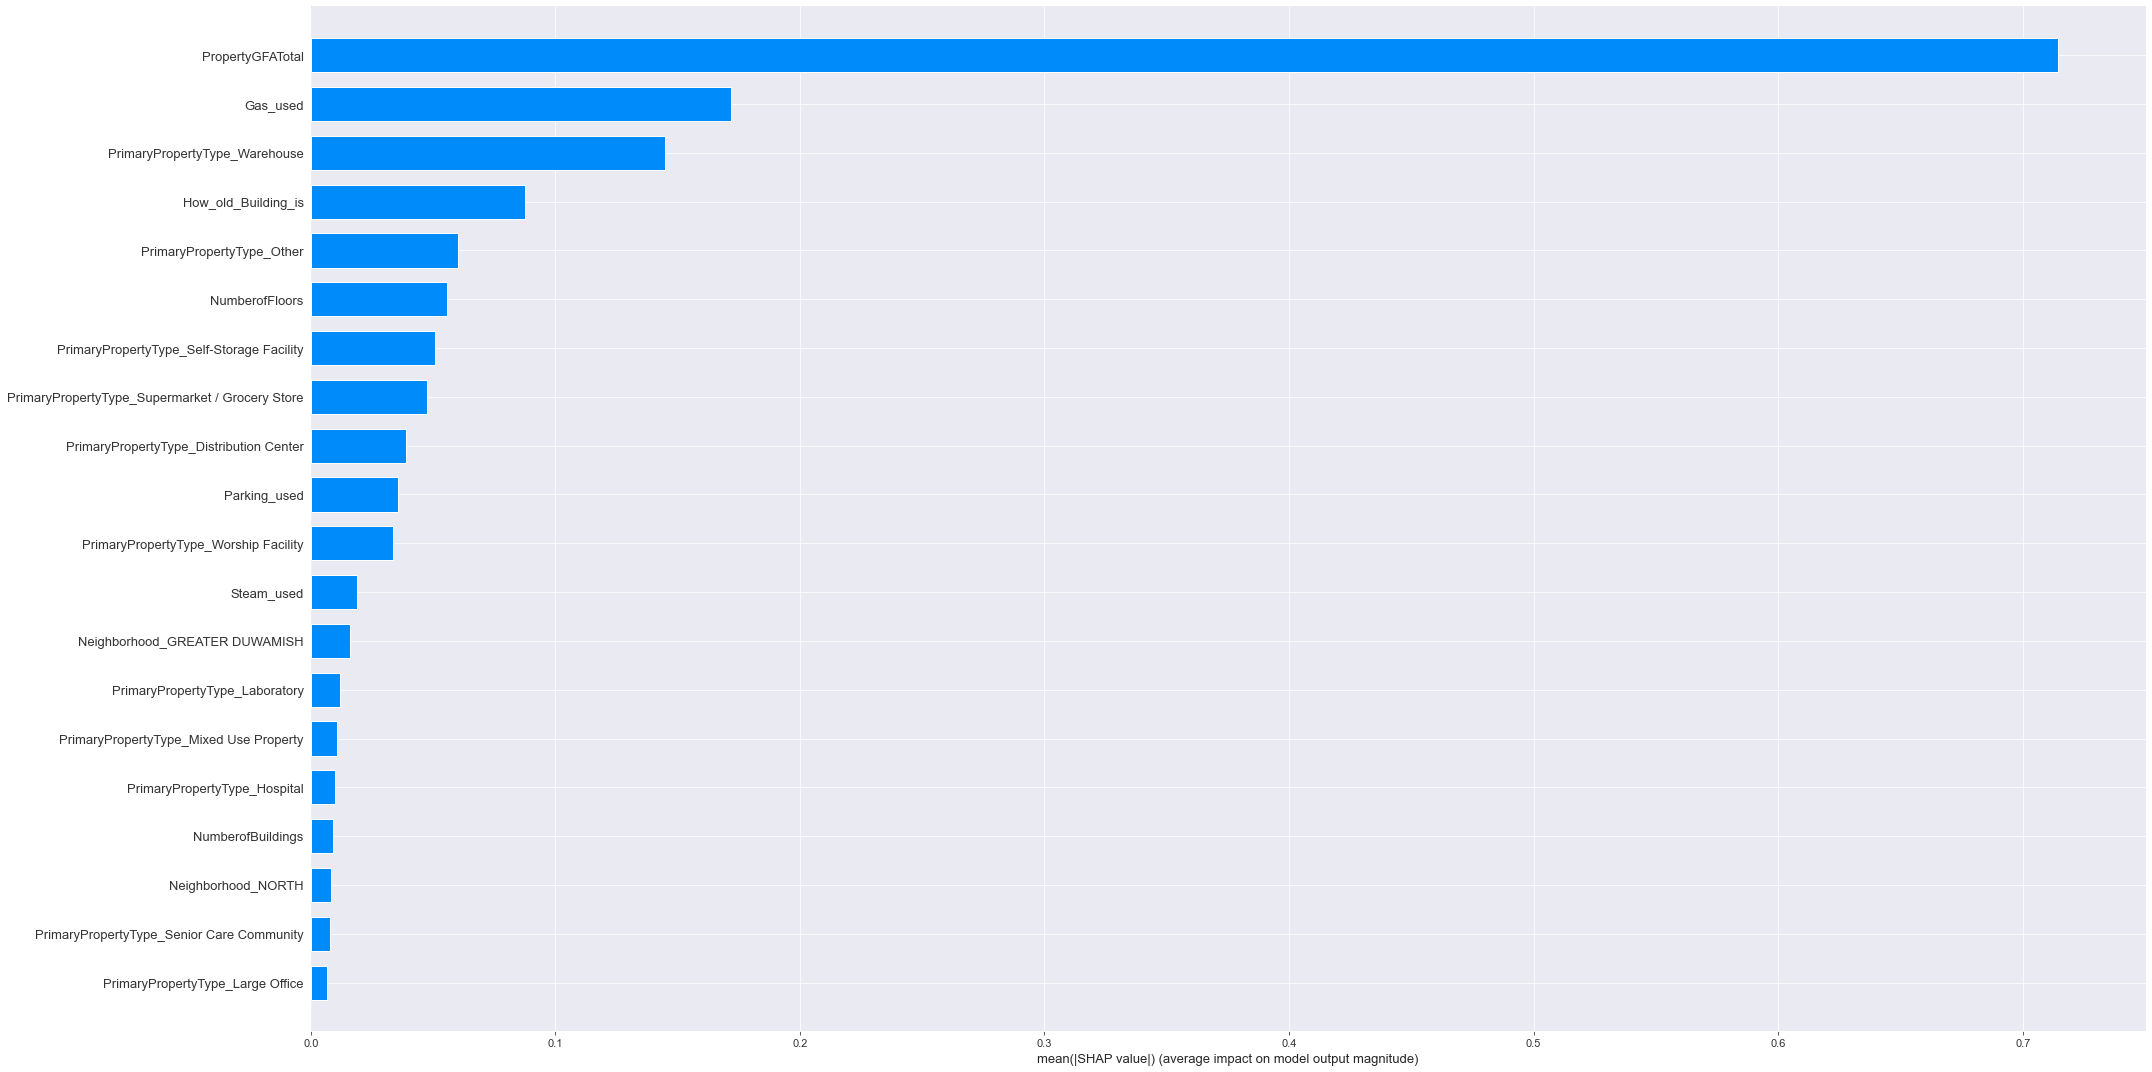

In [116]:

# Affichage du graphique avec les variables et leurs importances par rapport à la variable cible

shap.summary_plot(shap_values,                                                             # Use Shap values array
                  features = X_train,                                                      # Use training set features
                  feature_names = X.columns,                                               # Use column names
                  show = False,                                                            # Set to false to output to folder
                  plot_size = (30,15),                                                     # Change plot size
                  plot_type = 'bar'
                  )

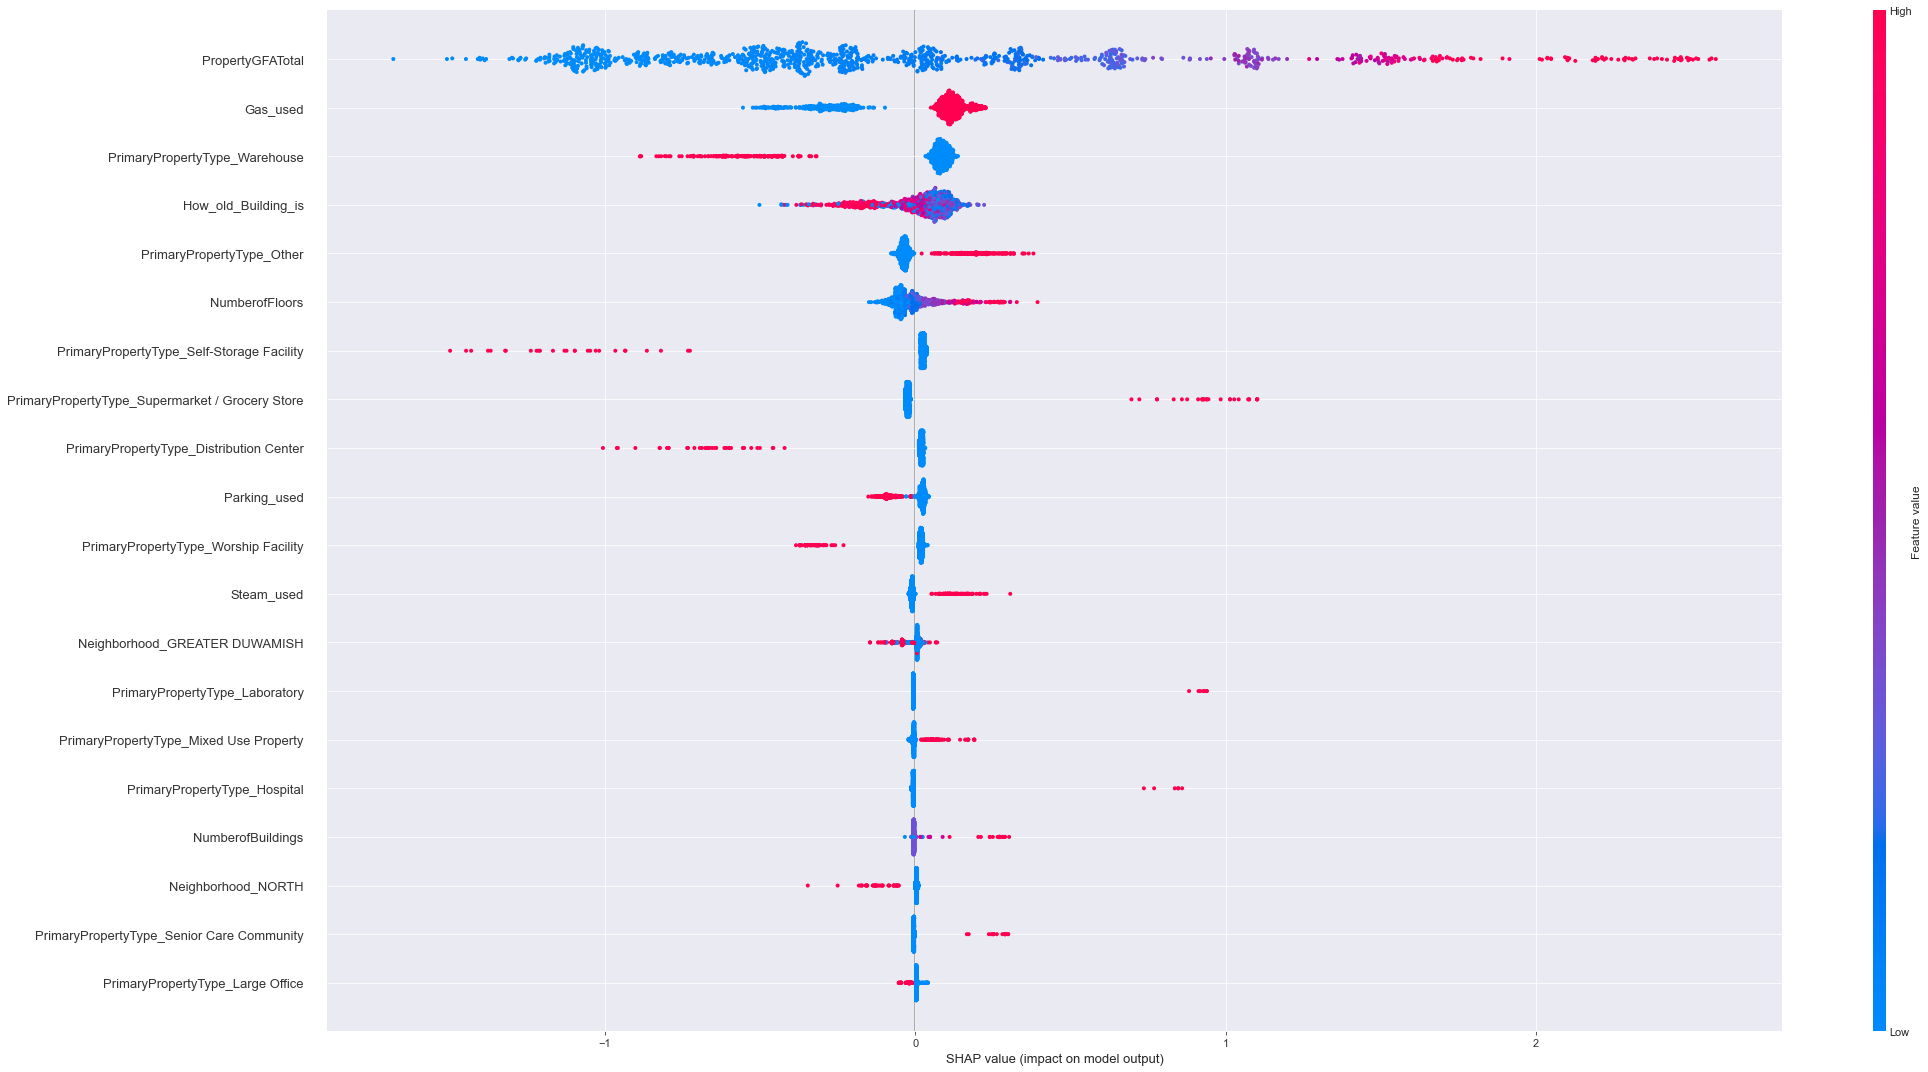

In [117]:
plt_shap = shap.summary_plot(shap_values,                           # Use Shap values array
                             features = X_train,                    # Use training set features
                             feature_names = X.columns,             # Use column names
                             show = False,                          # Set to false to output to folder
                             plot_size = (30,15))                   # Change plot size

##
## Section 5 : Avec l'ajout de la features "ENERGYSTARScore"

In [119]:

# On sélectionne nos variables et on ajoute la variable 'ENERGYSTARScore'

df20 = df6[['PrimaryPropertyType','Neighborhood', 'PropertyGFATotal', 'Parking_used', 'NumberofBuildings', 'NumberofFloors', 'How_old_Building_is', 'Electricity_used', 'Gas_used', 'Steam_used', 'ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']]
df20

,PrimaryPropertyType,Neighborhood,PropertyGFATotal,Parking_used,NumberofBuildings,NumberofFloors,How_old_Building_is,Electricity_used,Gas_used,Steam_used,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions
0,Hotel,DOWNTOWN,88434,0,1.0,12,95,1,1,1,60.0,7.456910e+06,249.98
1,Hotel,DOWNTOWN,103566,1,1.0,11,26,1,1,0,61.0,8.664479e+06,295.86
2,Hotel,DOWNTOWN,956110,1,1.0,41,53,1,1,1,43.0,7.393711e+07,2089.28
3,Hotel,DOWNTOWN,61320,0,1.0,10,96,1,1,1,56.0,6.946800e+06,286.43
4,Hotel,DOWNTOWN,175580,1,1.0,18,42,1,1,0,75.0,1.465650e+07,505.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,Office,GREATER DUWAMISH,12294,0,1.0,1,32,1,1,0,46.0,9.430032e+05,20.94
3372,Other,DOWNTOWN,16000,0,1.0,1,18,1,1,0,NaN,1.053706e+06,32.17
3373,Other,MAGNOLIA / QUEEN ANNE,13157,0,1.0,1,48,1,1,0,NaN,6.053764e+06,223.54
3374,Mixed Use Property,GREATER DUWAMISH,14101,0,1.0,1,33,1,1,0,NaN,7.828413e+05,22.11


In [193]:
# Nous préparons nos données pour le One-hot encoding
# Nous séparons les variables catégorielles

categorial_df20 = df20.select_dtypes(include = 'object')
categorial_df20

,PrimaryPropertyType,Neighborhood
0,Hotel,DOWNTOWN
1,Hotel,DOWNTOWN
2,Hotel,DOWNTOWN
3,Hotel,DOWNTOWN
4,Hotel,DOWNTOWN
...,...,...
3371,Office,GREATER DUWAMISH
3372,Other,DOWNTOWN
3373,Other,MAGNOLIA / QUEEN ANNE
3374,Mixed Use Property,GREATER DUWAMISH


In [121]:

# Nous séparons les variables numériques

numerical_df20 = df20.select_dtypes(include = ('int32', 'int64', 'float64'))
numerical_df20

,PropertyGFATotal,Parking_used,NumberofBuildings,NumberofFloors,How_old_Building_is,Electricity_used,Gas_used,Steam_used,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions
0,88434,0,1.0,12,95,1,1,1,60.0,7.456910e+06,249.98
1,103566,1,1.0,11,26,1,1,0,61.0,8.664479e+06,295.86
2,956110,1,1.0,41,53,1,1,1,43.0,7.393711e+07,2089.28
3,61320,0,1.0,10,96,1,1,1,56.0,6.946800e+06,286.43
4,175580,1,1.0,18,42,1,1,0,75.0,1.465650e+07,505.01
...,...,...,...,...,...,...,...,...,...,...,...
3371,12294,0,1.0,1,32,1,1,0,46.0,9.430032e+05,20.94
3372,16000,0,1.0,1,18,1,1,0,NaN,1.053706e+06,32.17
3373,13157,0,1.0,1,48,1,1,0,NaN,6.053764e+06,223.54
3374,14101,0,1.0,1,33,1,1,0,NaN,7.828413e+05,22.11


In [122]:

# Visualisation des valeurs manquantes

numerical_df20.isna().sum()

PropertyGFATotal           0
Parking_used               0
NumberofBuildings          0
NumberofFloors             0
How_old_Building_is        0
Electricity_used           0
Gas_used                   0
Steam_used                 0
ENERGYSTARScore          528
SiteEnergyUseWN(kBtu)      0
TotalGHGEmissions          0
dtype: int64

In [123]:

# Création des variables dummies

categorial_df20_dummies = pd.get_dummies(categorial_df20)
categorial_df20_dummies

,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Office,...,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3373,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3374,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [124]:

# Concaténation des variables créées

df21 = pd.concat([numerical_df20, categorial_df20_dummies], axis = 1)
df21

,PropertyGFATotal,Parking_used,NumberofBuildings,NumberofFloors,How_old_Building_is,Electricity_used,Gas_used,Steam_used,ENERGYSTARScore,SiteEnergyUseWN(kBtu),...,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST
0,88434,0,1.0,12,95,1,1,1,60.0,7.456910e+06,...,0,0,0,0,0,0,0,0,0,0
1,103566,1,1.0,11,26,1,1,0,61.0,8.664479e+06,...,0,0,0,0,0,0,0,0,0,0
2,956110,1,1.0,41,53,1,1,1,43.0,7.393711e+07,...,0,0,0,0,0,0,0,0,0,0
3,61320,0,1.0,10,96,1,1,1,56.0,6.946800e+06,...,0,0,0,0,0,0,0,0,0,0
4,175580,1,1.0,18,42,1,1,0,75.0,1.465650e+07,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,12294,0,1.0,1,32,1,1,0,46.0,9.430032e+05,...,1,0,0,0,0,0,0,0,0,0
3372,16000,0,1.0,1,18,1,1,0,NaN,1.053706e+06,...,0,0,0,0,0,0,0,0,0,0
3373,13157,0,1.0,1,48,1,1,0,NaN,6.053764e+06,...,0,0,1,0,0,0,0,0,0,0
3374,14101,0,1.0,1,33,1,1,0,NaN,7.828413e+05,...,1,0,0,0,0,0,0,0,0,0


In [125]:

# Nous passons les variables à prédire au log

df21['SiteEnergyUseWN(kBtu)'] = np.log(df21['SiteEnergyUseWN(kBtu)'])
df21['TotalGHGEmissions'] = np.log(df21['TotalGHGEmissions'])
df21

,PropertyGFATotal,Parking_used,NumberofBuildings,NumberofFloors,How_old_Building_is,Electricity_used,Gas_used,Steam_used,ENERGYSTARScore,SiteEnergyUseWN(kBtu),...,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST
0,88434,0,1.0,12,95,1,1,1,60.0,15.824652,...,0,0,0,0,0,0,0,0,0,0
1,103566,1,1.0,11,26,1,1,0,61.0,15.974742,...,0,0,0,0,0,0,0,0,0,0
2,956110,1,1.0,41,53,1,1,1,43.0,18.118725,...,0,0,0,0,0,0,0,0,0,0
3,61320,0,1.0,10,96,1,1,1,56.0,15.753792,...,0,0,0,0,0,0,0,0,0,0
4,175580,1,1.0,18,42,1,1,0,75.0,16.500395,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,12294,0,1.0,1,32,1,1,0,46.0,13.756825,...,1,0,0,0,0,0,0,0,0,0
3372,16000,0,1.0,1,18,1,1,0,NaN,13.867824,...,0,0,0,0,0,0,0,0,0,0
3373,13157,0,1.0,1,48,1,1,0,NaN,15.616191,...,0,0,1,0,0,0,0,0,0,0
3374,14101,0,1.0,1,33,1,1,0,NaN,13.570685,...,1,0,0,0,0,0,0,0,0,0


In [162]:
# On crée X et y

y3 = df21['SiteEnergyUseWN(kBtu)']
X3 = df21.drop(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'],axis = 1)


In [174]:
X3.columns

Index(['PropertyGFATotal', 'Parking_used', 'NumberofBuildings',
       'NumberofFloors', 'How_old_Building_is', 'Electricity_used', 'Gas_used',
       'Steam_used', 'ENERGYSTARScore',
       'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Low-Rise Multifamily',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Office',
       'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Residence Hall', 'PrimaryPropertyType_Restaurant',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Senior Care Community',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Sup

In [163]:

# On sépare jeu d'entrainement / jeu de test

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.2, random_state = 50)


In [164]:
X3_train

,PropertyGFATotal,Parking_used,NumberofBuildings,NumberofFloors,How_old_Building_is,Electricity_used,Gas_used,Steam_used,ENERGYSTARScore,PrimaryPropertyType_Distribution Center,...,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST
972,41790,0,1.0,2,53,1,1,0,NaN,0,...,1,0,0,0,0,0,0,0,0,0
3109,24697,0,1.0,1,57,1,1,0,NaN,0,...,0,0,0,1,0,0,0,0,0,0
341,159700,1,1.0,5,19,1,1,0,NaN,0,...,0,1,0,0,0,0,0,0,0,0
2147,51664,0,3.0,1,34,1,1,0,NaN,0,...,1,0,0,0,0,0,0,0,0,0
2783,74840,0,1.0,2,35,1,1,0,48.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,96910,1,1.0,6,20,1,1,0,56.0,0,...,0,0,1,0,0,0,0,0,0,0
185,128766,0,1.0,7,108,1,1,0,NaN,0,...,0,0,0,0,0,0,0,0,0,0
2721,33018,0,1.0,4,97,1,1,0,49.0,0,...,0,0,0,0,0,0,0,0,0,0
146,50292,0,1.0,2,96,1,0,0,NaN,0,...,0,0,1,0,0,0,0,0,0,0


In [165]:

# On utilise le KNNImputer pour remplacer les valeurs manquantes

knn = KNNImputer(n_neighbors = 10)

In [166]:

# On entraîne et on transforme

kn_n = knn.fit_transform(X3_train)

In [167]:

# On affiche la DataFrame obtenu

X3_train = pd.DataFrame(kn_n, columns = X3_train.columns)
X3_train

,PropertyGFATotal,Parking_used,NumberofBuildings,NumberofFloors,How_old_Building_is,Electricity_used,Gas_used,Steam_used,ENERGYSTARScore,PrimaryPropertyType_Distribution Center,...,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST
0,41790.0,0.0,1.0,2.0,53.0,1.0,1.0,0.0,53.1,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24697.0,0.0,1.0,1.0,57.0,1.0,1.0,0.0,63.7,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,159700.0,1.0,1.0,5.0,19.0,1.0,1.0,0.0,59.8,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,51664.0,0.0,3.0,1.0,34.0,1.0,1.0,0.0,58.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,74840.0,0.0,1.0,2.0,35.0,1.0,1.0,0.0,48.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,96910.0,1.0,1.0,6.0,20.0,1.0,1.0,0.0,56.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1208,128766.0,0.0,1.0,7.0,108.0,1.0,1.0,0.0,64.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1209,33018.0,0.0,1.0,4.0,97.0,1.0,1.0,0.0,49.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1210,50292.0,0.0,1.0,2.0,96.0,1.0,0.0,0.0,61.6,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [168]:

# On transforme X3_test sans le fit

kn_nt = knn.transform(X3_test)

In [169]:

# On affiche X3_test

X3_test = pd.DataFrame(kn_nt, columns = X3_test.columns)
X3_test

,PropertyGFATotal,Parking_used,NumberofBuildings,NumberofFloors,How_old_Building_is,Electricity_used,Gas_used,Steam_used,ENERGYSTARScore,PrimaryPropertyType_Distribution Center,...,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST
0,88592.0,1.0,1.0,6.0,21.0,1.0,1.0,0.0,84.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,40029.0,0.0,1.0,2.0,40.0,1.0,0.0,0.0,69.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20484.0,0.0,1.0,1.0,68.0,1.0,1.0,0.0,69.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,54015.0,0.0,1.0,5.0,40.0,1.0,0.0,0.0,75.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,71283.0,0.0,1.0,3.0,106.0,1.0,1.0,0.0,41.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,41704.0,1.0,1.0,4.0,32.0,1.0,1.0,0.0,73.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
299,34545.0,0.0,1.0,3.0,42.0,1.0,0.0,0.0,29.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300,64984.0,0.0,1.0,1.0,56.0,1.0,1.0,0.0,72.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
301,31300.0,0.0,1.0,1.0,44.0,1.0,1.0,0.0,89.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##
#### Entrainement du modèle et prédiction

In [170]:

# Mise à l'échelle des données

scaler = StandardScaler()
scaler.fit(X3_train)
X3_train = scaler.transform(X3_train)
X3_test = scaler.transform(X3_test)

In [173]:

# On entraîne notre modèle sur nos nouvelles données

modelxgboost = XGBRegressor(learning_rate = 0.1, subsample = 0.7, max_depth = 4, gamma = 0.5, alpha = 0.1)

modelxgboost.fit(X3_train, y3_train, eval_metric = 'rmse', eval_set = [(X3_test, y3_test)])

[0]	validation_0-rmse:13.18756
[1]	validation_0-rmse:11.89106
[2]	validation_0-rmse:10.72435
[3]	validation_0-rmse:9.67148
[4]	validation_0-rmse:8.72485
[5]	validation_0-rmse:7.86782
[6]	validation_0-rmse:7.09700
[7]	validation_0-rmse:6.40647
[8]	validation_0-rmse:5.78513
[9]	validation_0-rmse:5.22335
[10]	validation_0-rmse:4.71717
[11]	validation_0-rmse:4.26417
[12]	validation_0-rmse:3.86005
[13]	validation_0-rmse:3.49495
[14]	validation_0-rmse:3.16278
[15]	validation_0-rmse:2.86814
[16]	validation_0-rmse:2.60095
[17]	validation_0-rmse:2.36242
[18]	validation_0-rmse:2.15389
[19]	validation_0-rmse:1.96174
[20]	validation_0-rmse:1.78927
[21]	validation_0-rmse:1.63286
[22]	validation_0-rmse:1.49787
[23]	validation_0-rmse:1.37941
[24]	validation_0-rmse:1.27232
[25]	validation_0-rmse:1.17657
[26]	validation_0-rmse:1.09651
[27]	validation_0-rmse:1.02841


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[28]	validation_0-rmse:0.96498
[29]	validation_0-rmse:0.90607
[30]	validation_0-rmse:0.85835
[31]	validation_0-rmse:0.81383
[32]	validation_0-rmse:0.77720
[33]	validation_0-rmse:0.74489
[34]	validation_0-rmse:0.71870
[35]	validation_0-rmse:0.69641
[36]	validation_0-rmse:0.67554
[37]	validation_0-rmse:0.65920
[38]	validation_0-rmse:0.64305
[39]	validation_0-rmse:0.62948
[40]	validation_0-rmse:0.61844
[41]	validation_0-rmse:0.60788
[42]	validation_0-rmse:0.59921
[43]	validation_0-rmse:0.59384
[44]	validation_0-rmse:0.58599
[45]	validation_0-rmse:0.57968
[46]	validation_0-rmse:0.57354
[47]	validation_0-rmse:0.56819
[48]	validation_0-rmse:0.56124
[49]	validation_0-rmse:0.56015
[50]	validation_0-rmse:0.55661
[51]	validation_0-rmse:0.55332
[52]	validation_0-rmse:0.55055
[53]	validation_0-rmse:0.54810
[54]	validation_0-rmse:0.54703
[55]	validation_0-rmse:0.54471
[56]	validation_0-rmse:0.54215
[57]	validation_0-rmse:0.54215
[58]	validation_0-rmse:0.54062
[59]	validation_0-rmse:0.53887
[60]	val

XGBRegressor(alpha=0.1, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.100000001, ...)

In [176]:

# On affiche la prédiction

y3_pred = modelxgboost.predict(X3_test)

In [177]:

# On utilise une fonction inverse pour la mise au log de départ

y3_pred = transformer.inverse_transform(y3_pred)
y3_pred

array([15.224052 , 14.361647 , 13.583523 , 15.024346 , 14.399653 ,
       15.751015 , 14.936438 , 15.9190035, 13.851955 , 15.178719 ,
       17.250902 , 15.758762 , 14.085917 , 14.50448  , 14.076833 ,
       14.846914 , 16.91594  , 15.536081 , 13.480348 , 16.769423 ,
       13.699664 , 14.217219 , 15.506365 , 16.793905 , 15.30482  ,
       15.164218 , 17.155973 , 13.238188 , 14.145381 , 13.736405 ,
       13.9975   , 14.740482 , 13.214692 , 14.749516 , 14.911269 ,
       13.555428 , 13.988266 , 15.317258 , 14.352993 , 14.968667 ,
       17.089006 , 14.968921 , 14.6052   , 16.523296 , 15.799772 ,
       15.612869 , 15.864571 , 13.209847 , 15.607951 , 15.380463 ,
       17.033438 , 13.447    , 14.843943 , 15.062188 , 15.800829 ,
       15.535167 , 17.28005  , 16.38734  , 14.958188 , 15.937001 ,
       14.47485  , 17.072498 , 15.3207245, 14.133436 , 17.0205   ,
       14.432359 , 16.034399 , 15.377297 , 13.729741 , 16.545591 ,
       15.201526 , 14.205865 , 16.994877 , 15.806151 , 14.5742

In [178]:

# On affiche le coefficient de détermination

r2_score(y3_test, y3_pred)


0.8200151253752019

In [179]:

# On affiche l'erreur absolue moyenne

mean_absolute_error(y3_test, y3_pred)


0.38063339515625716

In [196]:

# On affiche l'erreur quadratique moyenne

mse_ = mean_squared_error(y3_test, y3_pred)
mse_

0.2707716461961942

In [198]:

# On affiche la racine de l'erreur quadratique moyenne

rmse_ = np.sqrt(mse_)
rmse

0.5730924113954784

##
### Features Importance avec "ENERGYSTARScore"

In [181]:
classement_E = XGBRegressor(learning_rate=0.1,
                          subsample=0.7,
                          max_depth=4,
                          gamma=0.5,
                          alpha=0.1
                          )



In [182]:

# On entraine notre modèle avec nos nouvelles valeurs

classement_E.fit(X3_train, y3_train)

XGBRegressor(alpha=0.1, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.100000001, ...)

In [199]:

print("Predictions du test set :")

y3_pred = classement_E.predict(X3_test)
y3_pred

Predictions du test set :


array([15.224052 , 14.361647 , 13.583523 , 15.024346 , 14.399653 ,
       15.751015 , 14.936438 , 15.9190035, 13.851955 , 15.178719 ,
       17.250902 , 15.758762 , 14.085917 , 14.50448  , 14.076833 ,
       14.846914 , 16.91594  , 15.536081 , 13.480348 , 16.769423 ,
       13.699664 , 14.217219 , 15.506365 , 16.793905 , 15.30482  ,
       15.164218 , 17.155973 , 13.238188 , 14.145381 , 13.736405 ,
       13.9975   , 14.740482 , 13.214692 , 14.749516 , 14.911269 ,
       13.555428 , 13.988266 , 15.317258 , 14.352993 , 14.968667 ,
       17.089006 , 14.968921 , 14.6052   , 16.523296 , 15.799772 ,
       15.612869 , 15.864571 , 13.209847 , 15.607951 , 15.380463 ,
       17.033438 , 13.447    , 14.843943 , 15.062188 , 15.800829 ,
       15.535167 , 17.28005  , 16.38734  , 14.958188 , 15.937001 ,
       14.47485  , 17.072498 , 15.3207245, 14.133436 , 17.0205   ,
       14.432359 , 16.034399 , 15.377297 , 13.729741 , 16.545591 ,
       15.201526 , 14.205865 , 16.994877 , 15.806151 , 14.5742

In [186]:

# On utilise Tree Shap pour expliquer les influences sur la cible, algorithme basé sur les modèles d'arbres de décisions

explainer_E = shap.TreeExplainer(classement_E)
shap_values_E = explainer_E.shap_values(X3_train)

# View shap values
print(shap_values_E)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


[[-3.6147985e-01  2.5055729e-02 -5.3654877e-03 ... -2.9341885e-05
  -7.8026403e-04 -3.2405888e-03]
 [-1.0269532e+00  2.4648597e-02 -5.1779202e-03 ... -2.9341885e-05
   2.9377989e-06 -3.6437372e-03]
 [ 1.0957413e+00  3.2194741e-03 -5.2476847e-03 ... -2.7647044e-05
  -7.9698593e-04 -3.3284503e-03]
 ...
 [-5.3545272e-01  3.1231560e-02 -4.9273949e-03 ... -2.9341885e-05
  -3.7225109e-04 -3.7300466e-03]
 [-2.2366998e-01  1.5999453e-02 -5.5399779e-03 ... -2.9341885e-05
  -7.7942765e-04 -2.3375917e-03]
 [-8.9107955e-01  2.0376785e-02 -5.3288690e-03 ... -2.9341885e-05
   3.7903455e-03 -4.1854586e-03]]


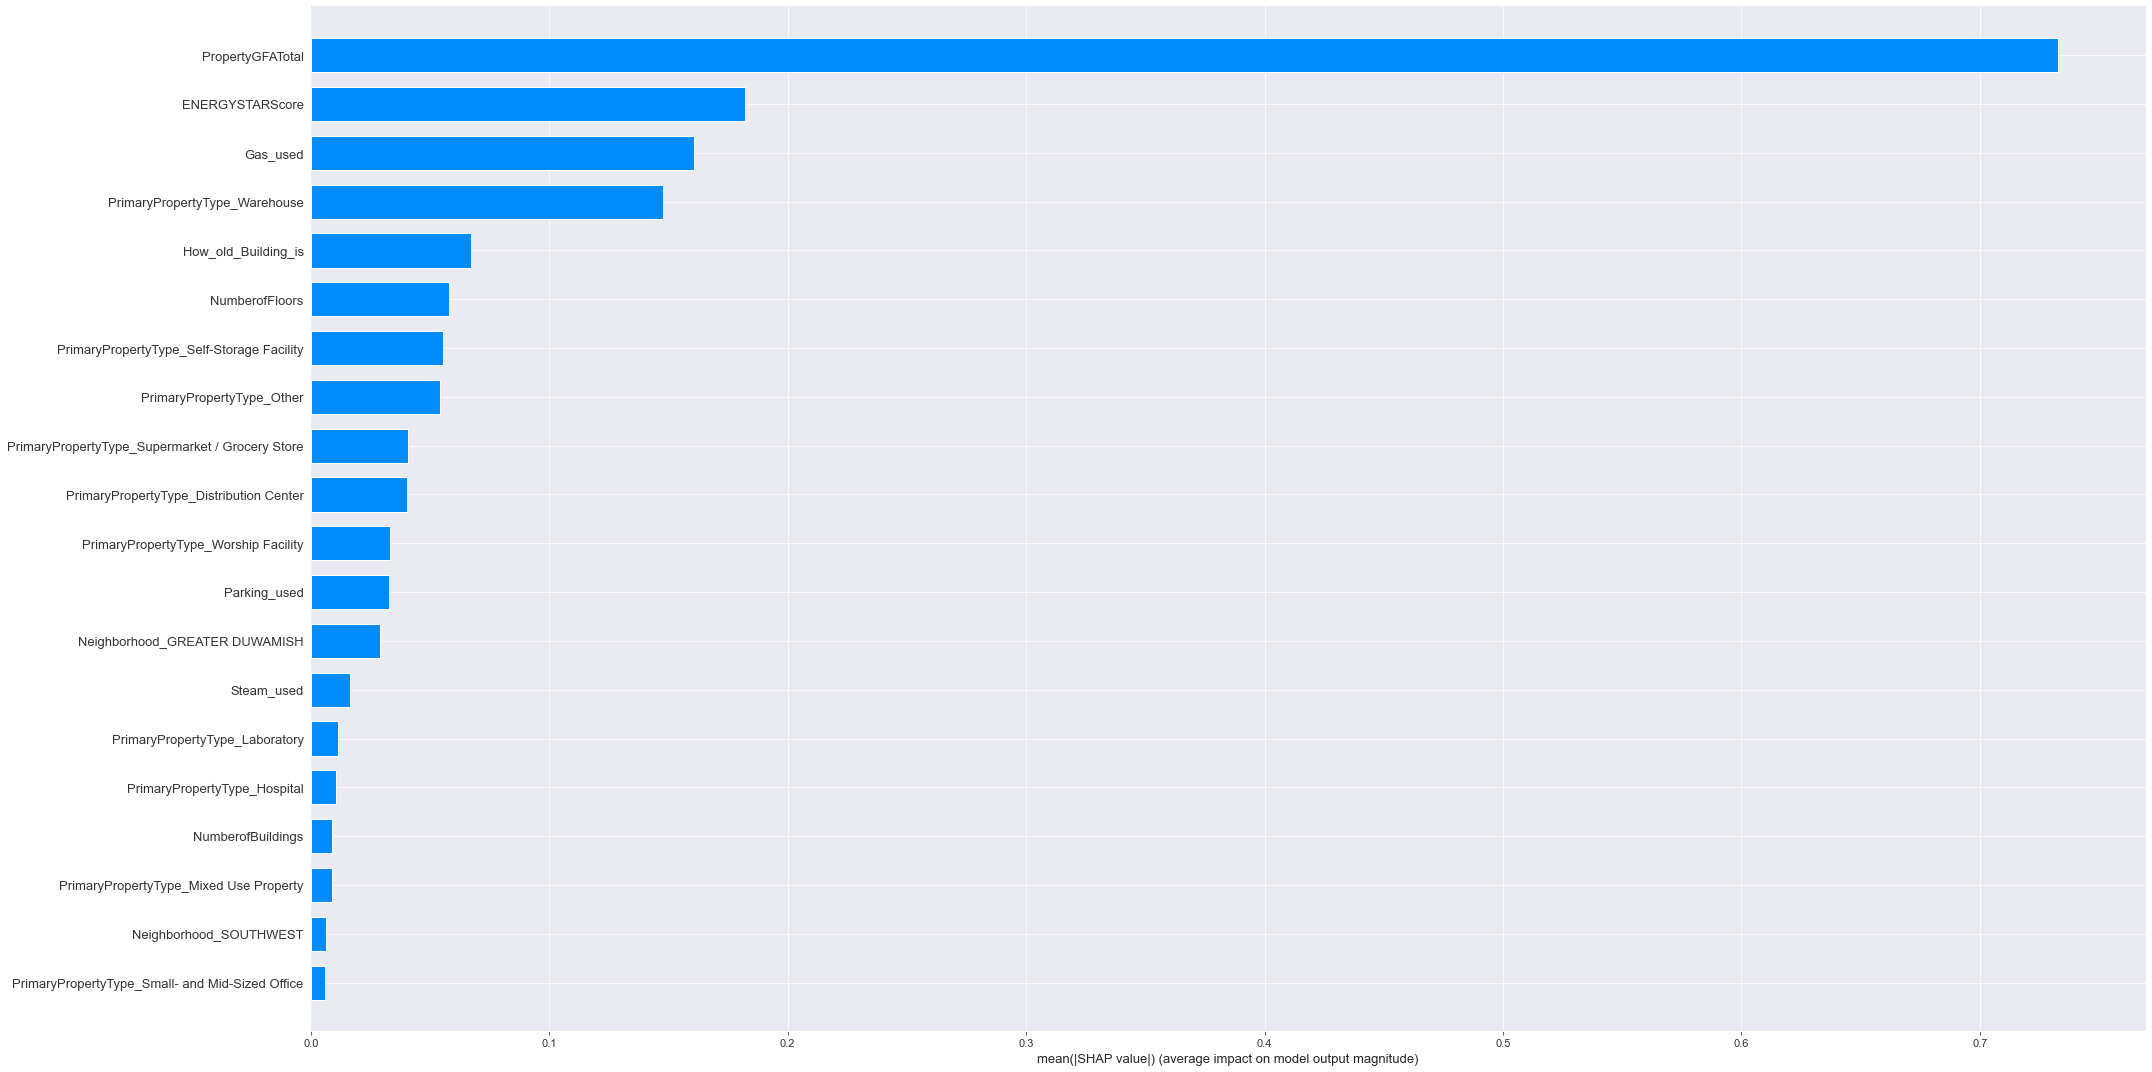

In [187]:

# Affichage du graphique avec les variables et leurs importances par rapport à la variable cible

shap.summary_plot(shap_values_E,                                                            # Use Shap values array
                  features = X3_train,                                                      # Use training set features
                  feature_names = X3.columns,                                               # Use column names
                  show = False,                                                             # Set to false to output to folder
                  plot_size = (30,15),                                                      # Change plot size
                  plot_type = 'bar'
                  )

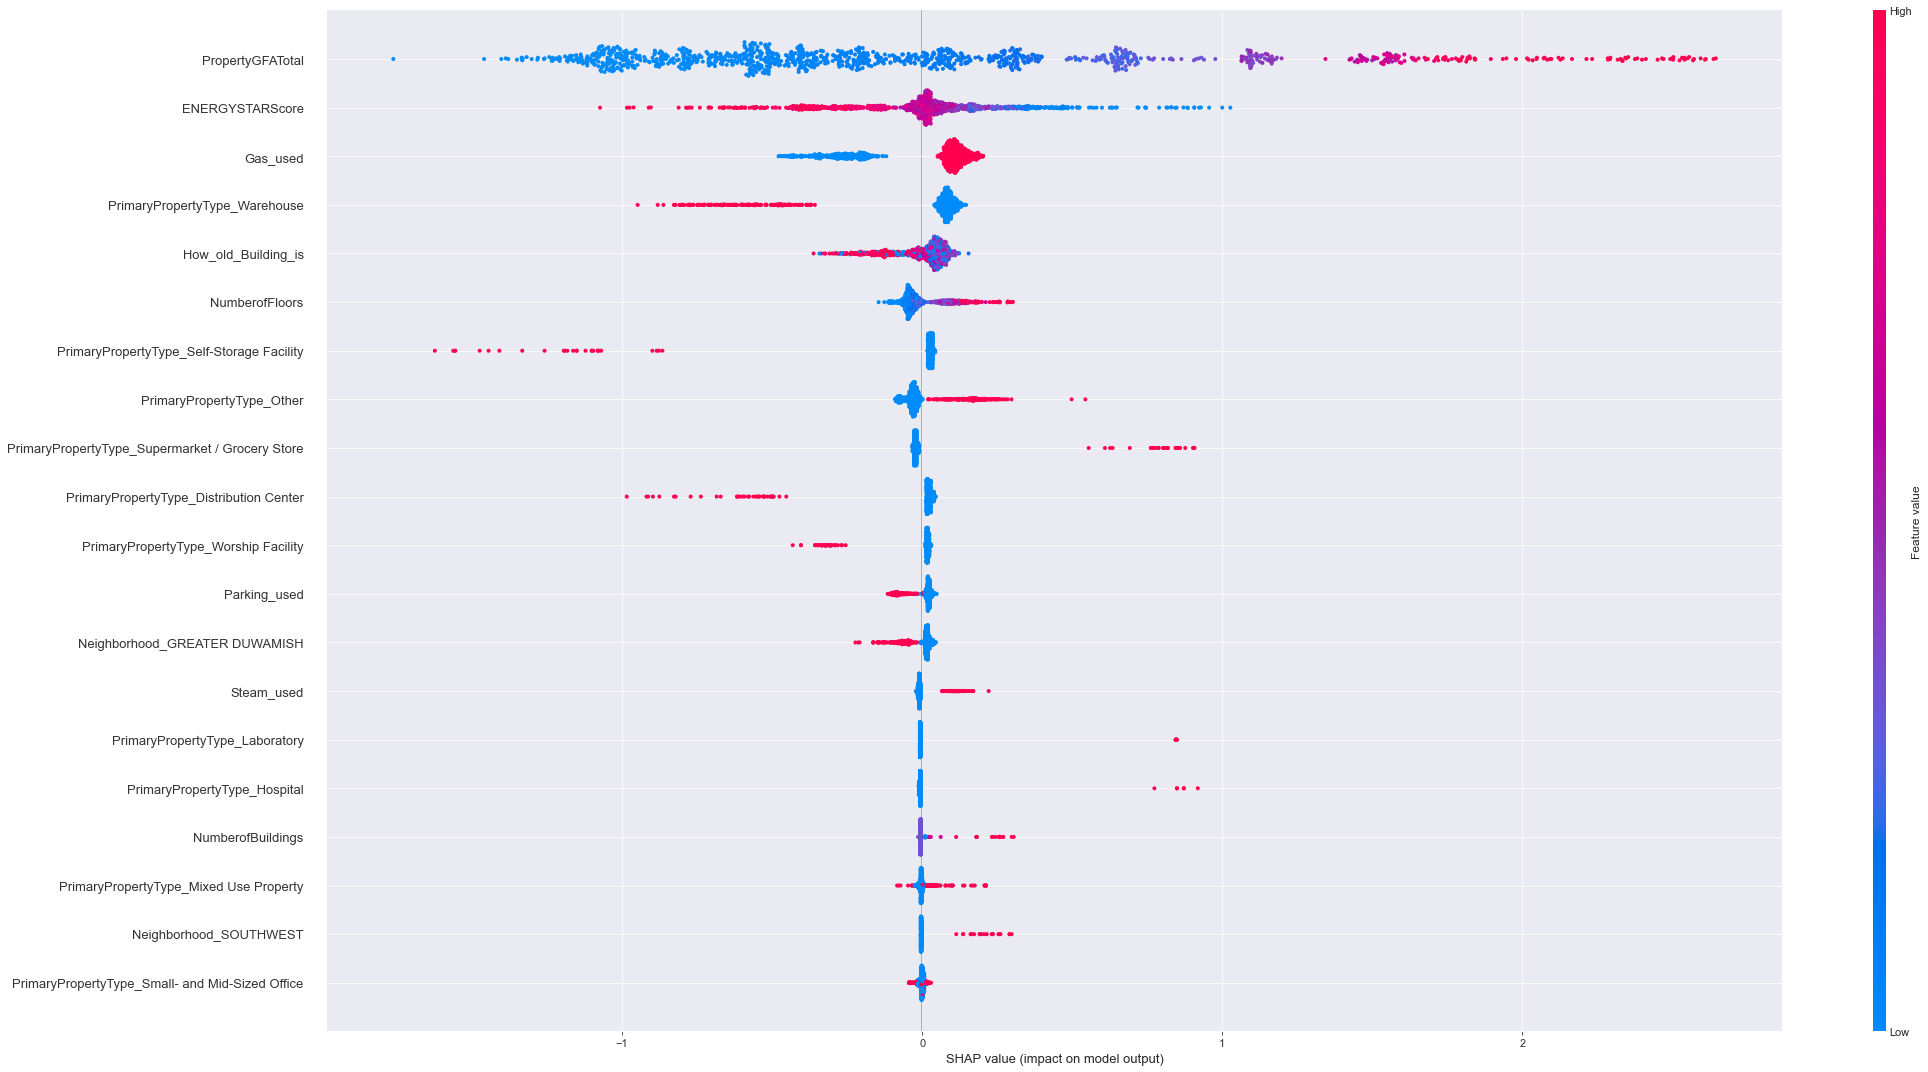

In [188]:

# Une autre manière de visualiser ces influences

plt_shap_E = shap.summary_plot(shap_values_E,                           # Use Shap values array
                             features = X3_train,                       # Use training set features
                             feature_names = X3.columns,                # Use column names
                             show = False,                              # Set to false to output to folder
                             plot_size = (30,15))                       # Change plot size